In [4]:
!pwd

/home/ggavriilidis/Mongoose


In [1]:
import scanpy as sc
import pandas as pd

# Mongoose demonstrator on Perturb-Map

This notebook provides a walkthrough of the pilot for Perturb-Map, which involves spatial transcriptomic datasets from an experiment in which lung cancer samples from a mouse model that had received sgRNAs targeting specific key oncogenic markers were sequenced. As of now, this is considered one of the very few spatial transcriptomic datasets that has actual knock-outs for certain genes and hence it is a dataset that can be used for method establishment and benchmarking.

Our purpose is to provide to Mongoose as input untreated tumor cells from the lung Tumor Microenvironemnt (TME) and then simulate a digital KO for certain oncogenic drivers. Once we have the Mongoose output, we will compare it with differentially expressed genes from regions of the spatial dataset that contain cells that have **actually** received CRISPR-KO for that given oncogenic driver.

https://db.cngb.org/stomics/datasets/STDS0000129/summary

## Data preparation

Initially, we are going to create the 2nd modality called "niche" modality which provides a spatially aware understanding of gene expression on the Visium dataset. Each value in the niche modality matrix corresponds to a weighted average expression of a gene, not just from the cell/spot itself, but from its neighbourhood — i.e., nearby cells or spots in space. **This provides a spatially aware glimpse on the gene expression, providing useful spatial context for our analysis.**

#### **Generating the niche expression modality**

Using the measured expression of RNAs of cells or spots, we incorporate the spatial information of each cell or spot and generate a weighted average expression of RNAs.

With two-dimensional spatial coordinates \( (s^1_i, s^2_i) \) and modality \( v \) with its \( i \)-th row \( x^{(v)}_i \) corresponding to cell/spot \( i \), we compute the niche modality for modality \( v \), denoted by \( x^{(v_{\text{niche}})} \), with \( v = 1, \ldots, V \).

For cell/spot \( i \), we compute:

$$
x^{(v_{\text{niche}})}_i = \sum_{j=1}^{J} x^{(v)}_j \cdot w_{ij}
$$

where \( j \in \{1, \ldots, J\} \) denotes the \( J \)-nearest neighbors of cell/spot \( i \), and \( w_{ij} \) is calculated by:

$$
w_{ij} = \frac{1}{\text{distance}\left((s^1_i, s^2_i), (s^1_j, s^2_j)\right)} \bigg/ \sum_{j=1}^{J} \frac{1}{\text{distance}\left((s^1_i, s^2_i), (s^1_j, s^2_j)\right)}
$$

where \( \text{distance}(\cdot) \) denotes the Euclidean distance between two vectors.


In [4]:
import gdown

In [5]:
!gdown 14GU21Pm6xCKa4cmpvxJCFz0HxnfGFrGF -O perturbmap_stomicsdb.zip

Downloading...
From (original): https://drive.google.com/uc?id=14GU21Pm6xCKa4cmpvxJCFz0HxnfGFrGF
From (redirected): https://drive.google.com/uc?id=14GU21Pm6xCKa4cmpvxJCFz0HxnfGFrGF&confirm=t&uuid=59f20562-9d3d-4da1-8a7f-42a4f384ceb9
To: /content/perturbmap_stomicsdb.zip
100% 334M/334M [00:04<00:00, 81.6MB/s]


In [6]:
!unzip perturbmap_stomicsdb.zip -d Data

Archive:  perturbmap_stomicsdb.zip
   creating: Data/perturbmap_stomicsdb/
  inflating: Data/perturbmap_stomicsdb/GSM5808054_10x_Visium_processed.h5ad  
  inflating: Data/__MACOSX/perturbmap_stomicsdb/._GSM5808054_10x_Visium_processed.h5ad  
  inflating: Data/perturbmap_stomicsdb/GSM5808056_10x_Visium_processed.h5ad  
  inflating: Data/__MACOSX/perturbmap_stomicsdb/._GSM5808056_10x_Visium_processed.h5ad  
  inflating: Data/perturbmap_stomicsdb/GSM5808057_10x_Visium_processed.h5ad  
  inflating: Data/__MACOSX/perturbmap_stomicsdb/._GSM5808057_10x_Visium_processed.h5ad  
  inflating: Data/perturbmap_stomicsdb/GSM5808055_10x_Visium_processed.h5ad  
  inflating: Data/__MACOSX/perturbmap_stomicsdb/._GSM5808055_10x_Visium_processed.h5ad  


In [7]:
!gdown --id 1_n5709YnZG8Ek7AfrZESjOHg66KijwhY
!unzip PertMap_metadata.zip -d PertMap_metadata

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_n5709YnZG8Ek7AfrZESjOHg66KijwhY
To: /content/PertMap_metadata.zip
100% 277k/277k [00:00<00:00, 74.1MB/s]
Archive:  PertMap_metadata.zip
 extracting: PertMap_metadata/PertMap_metadata/spot_annotation_KP1.csv  
 extracting: PertMap_metadata/PertMap_metadata/spot_annotation_KP2.csv  
 extracting: PertMap_metadata/PertMap_metadata/spot_annotation_KP3.csv  
 extracting: PertMap_metadata/PertMap_metadata/spot_annotation_KP4.csv  


In [2]:
adata = sc.read_h5ad('Data/perturbmap_stomicsdb/GSM5808054_10x_Visium_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 4992 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

We are adding phenotypic information to delineate which region has undergone CRISPR KO for some target and which is not.

In [6]:
!pwd

/home/ggavriilidis/Mongoose


In [9]:
# Load your CSV file
pheno = pd.read_csv("Data/PertMap_metadata/spot_annotation_KP1.csv")

# Ensure barcodes are the index for merging
pheno = pheno.set_index("barcode")

# Add phenotypes to adata.obs (matching on index)
adata.obs["phenotypes"] = adata.obs.index.map(pheno["phenotypes"])
adata.obs['kmeans'] = adata.obs.index.map(pheno["kmeans"])

In [10]:
adata

AnnData object with n_obs × n_vars = 4992 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

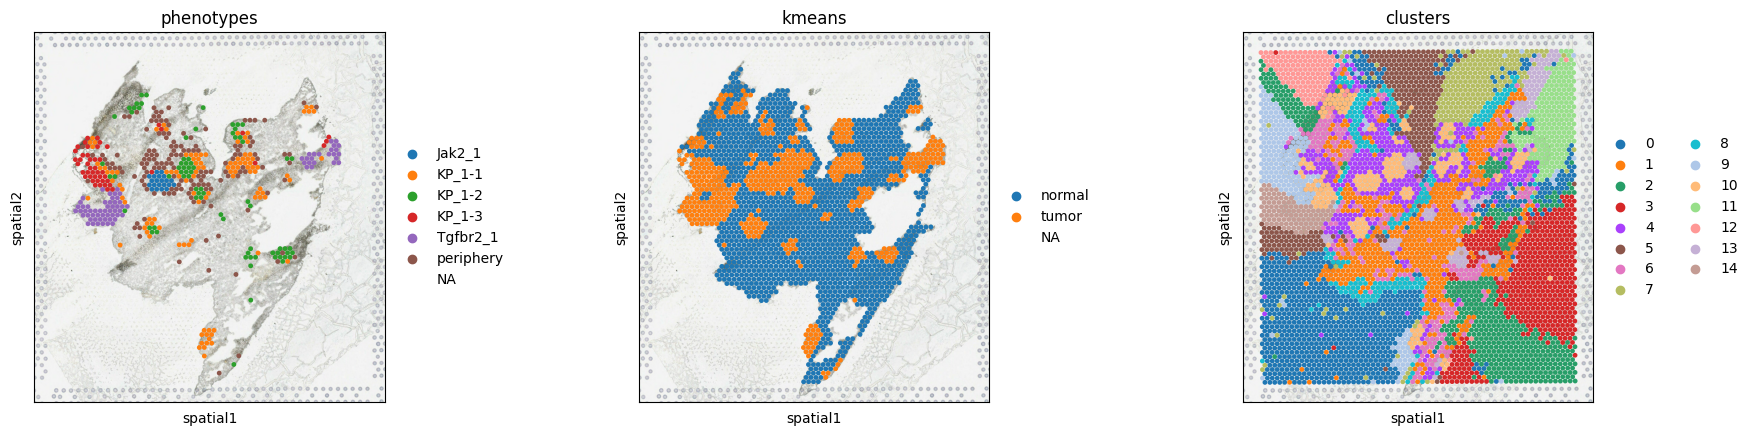

In [11]:
sc.pl.spatial(adata, img_key="hires", color=["phenotypes", 'kmeans', 'clusters'], size=1.5)

This confirms that we have retrieved the correct spatial dataset as shown Figure 5c from https://doi.org/10.1016/j.cell.2022.02.015

![image.png](attachment:108461b3-f044-4728-87b5-ecdb9e3148e0.png)

At this point, we are going to subset our Perturb-Map dataset to 2000 HVGs plus the 2 genes that have been targeted by CRISPR KO (Tgfbr2, Jak2).

In [ ]:
# # 1) Recompute HVGs to get exactly 2,000 (ignores any existing HVG flags)
# #    Pick your favorite flavor; seurat_v3 is common for scRNA/Visium.
# sc.pp.highly_variable_genes(
#     adata,
#     # flavor="seurat_v3",
#     n_top_genes=2000,
#     subset=False,
#     inplace=True
# )

# # 2) Build a keep mask: HVGs OR the two specific genes
# genes_to_force = {"Tgfbr2", "Jak2"}

# # If your gene symbols are in adata.var_names (common), this works as-is.
# # (If they’re under another column like 'gene_symbols', see the note below.)
# is_hvg = adata.var["highly_variable"].astype(bool).values
# is_forced = np.isin(adata.var_names, list(genes_to_force))
# keep_mask = is_hvg | is_forced

# # 3) Subset to 2,002 genes (will be 2,000 + any of the two present)
# adata = adata[:, keep_mask].copy()

# # Optional: sanity check
# present_forced = genes_to_force.intersection(set(adata.var_names))
# missing_forced = genes_to_force.difference(present_forced)
# print(f"Kept {adata.n_vars} genes. Forced present: {sorted(present_forced)}; missing: {sorted(missing_forced)}")


Kept 2002 genes. Forced present: ['Jak2', 'Tgfbr2']; missing: []


In [ ]:
adata

AnnData object with n_obs × n_vars = 4992 × 2002
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'phenotypes_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

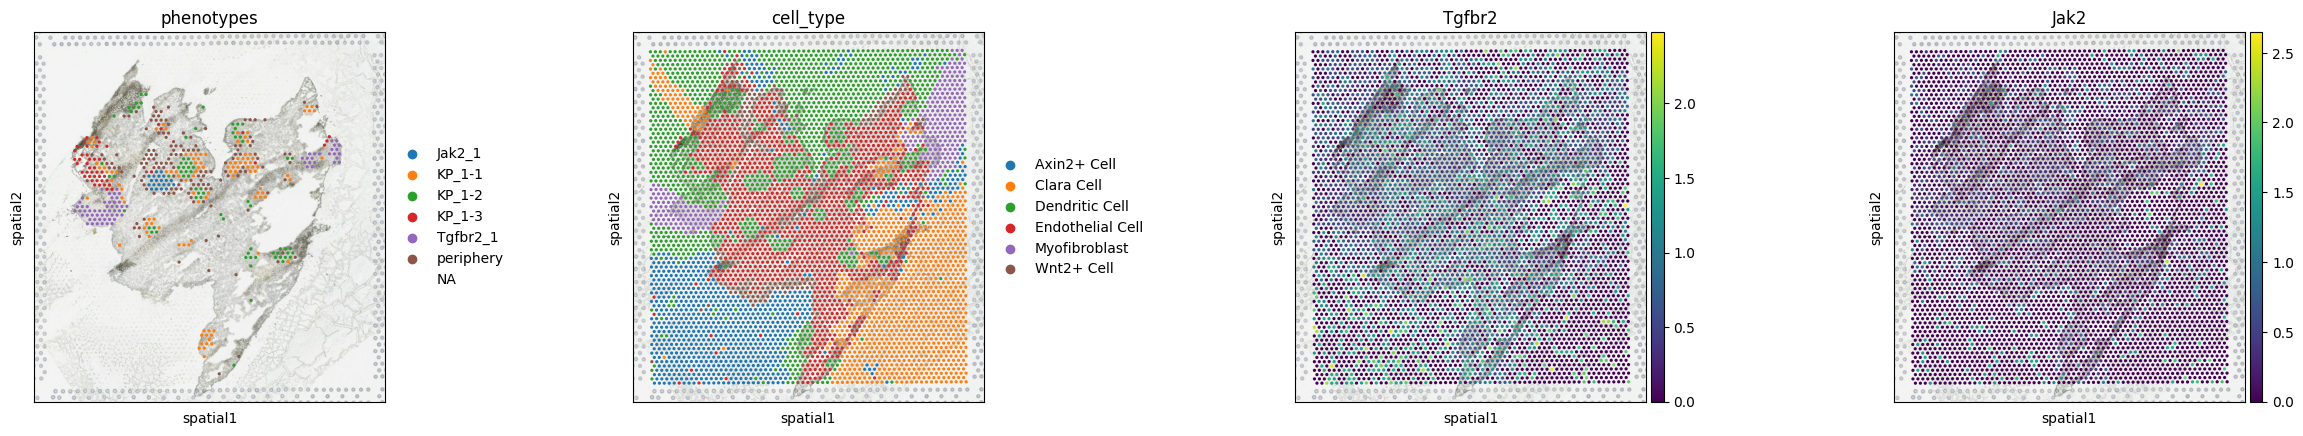

In [ ]:
sc.pl.spatial(adata, img_key="hires", color=["phenotypes", "cell_type", "Tgfbr2", "Jak2"])

In [14]:
# Define phenotype groups
excluded_tumors = ["KP_3-1", "KP_3-3", "KP_3-2", "KP_4-3", "KP_4-2", "KP_4-4", "KP_2-3", "KP_1-2", "KP_2-1", "KP_4-1"]
infl_tumors = ["KP_2-2", "KP_1-1", "KP_1-3"]
tgfb_tumors = ["Tgfbr2_4-1", "Tgfbr2_2", "Tgfbr2_1", "Tgfbr2_4-2"]
# ifng_tumors = ["Ifngr2_3", "Ifngr2_2"]
jak_tumors = ["Jak2_1"]

# Assign a new column for DE analysis
adata.obs["phenotypes_mod"] = adata.obs["phenotypes"].replace({
    **{p: "excluded_tumor" for p in excluded_tumors},
    **{p: "infl_tumor" for p in infl_tumors},
    **{p: "Tgfbr2_KO" for p in tgfb_tumors},
    # **{p: "Ifngr2_KO" for p in ifng_tumors},
    **{p: "Jak2_KO" for p in jak_tumors},
})

/tmp/ipython-input-3875865088.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["phenotypes_mod"] = adata.obs["phenotypes"].replace({


In [15]:


# --- 1) Build phenotypes_mod2 (copy your existing phenotypes_mod, then split Tgfbr2_1) ---
ph2 = adata.obs["phenotypes_mod"].astype(str).copy()

is_tgfbr2_1 = adata.obs["phenotypes"].astype(str) == "Tgfbr2_1"
is_dc  = adata.obs["cell_type"].astype(str) == "Dendritic Cell"
is_myo = adata.obs["cell_type"].astype(str) == "Myofibroblast"

ph2.loc[is_tgfbr2_1 & is_dc]  = "Tgfbr2_1_DC"
ph2.loc[is_tgfbr2_1 & is_myo] = "Tgfbr2_1_Myofibroblast"

adata.obs["phenotypes_mod2"] = pd.Categorical(ph2)

# --- 2) sanity check ---
print(adata.obs["phenotypes_mod2"].value_counts().sort_values(ascending=False))


phenotypes_mod2
nan                       4514
infl_tumor                 158
periphery                  149
excluded_tumor              75
Tgfbr2_1_Myofibroblast      49
Tgfbr2_1_DC                 25
Jak2_KO                     21
Tgfbr2_KO                    1
Name: count, dtype: int64


In [16]:
# --- 3) DE helpers (slice-based comparison to avoid other groups influencing the test) ---

def run_de_on_slice(adata, groupby, subgroup, reference, key, p_adj_cut=0.01, layer=None):
    # keep only subgroup + reference
    keep = adata.obs[groupby].isin([subgroup, reference])
    ad = adata[keep].copy()
    sc.tl.rank_genes_groups(
        ad, groupby=groupby,
        groups=[subgroup], reference=reference,
        method="wilcoxon", key_added=key, layer=layer
    )
    df = sc.get.rank_genes_groups_df(ad, group=subgroup, key=key)
    df_sig = df[df["pvals_adj"] < p_adj_cut].copy()
    out = f"DE_{subgroup}_vs_{reference}.csv"
    df_sig.to_csv(out, index=False)
    print(f"[{groupby}] {subgroup} vs {reference}: {len(df_sig)} DEGs (FDR<{p_adj_cut}) -> {out}")
    return df_sig

# Run DE for each Tgfbr2_1 subgroup vs excluded_tumor
de_tgf_dc  = run_de_on_slice(adata, "phenotypes_mod2", "Tgfbr2_1_DC",  "excluded_tumor", "de_tgf_dc")
de_tgf_myo = run_de_on_slice(adata, "phenotypes_mod2", "Tgfbr2_1_Myofibroblast", "excluded_tumor", "de_tgf_myo")


[phenotypes_mod2] Tgfbr2_1_DC vs excluded_tumor: 237 DEGs (FDR<0.01) -> DE_Tgfbr2_1_DC_vs_excluded_tumor.csv
[phenotypes_mod2] Tgfbr2_1_Myofibroblast vs excluded_tumor: 648 DEGs (FDR<0.01) -> DE_Tgfbr2_1_Myofibroblast_vs_excluded_tumor.csv


In [17]:
import pandas as pd
import scanpy as sc

# Start from phenotypes (keep original labels)
ph2 = adata.obs["phenotypes"].astype(str).copy()

# Masks
is_tgfbr2_1 = adata.obs["phenotypes"] == "Tgfbr2_1"
is_dc  = adata.obs["cell_type"] == "Dendritic Cell"
is_myo = adata.obs["cell_type"] == "Myofibroblast"

# Relabel
ph2.loc[is_tgfbr2_1 & is_dc]  = "Tgfbr2_1_DC"
ph2.loc[is_tgfbr2_1 & is_myo] = "Tgfbr2_1_Myofibroblast"

adata.obs["phenotypes_sub"] = pd.Categorical(ph2)

print(adata.obs["phenotypes_sub"].value_counts())


phenotypes_sub
nan                       4514
periphery                  149
KP_1-1                     110
KP_1-2                      75
Tgfbr2_1_Myofibroblast      49
KP_1-3                      48
Tgfbr2_1_DC                 25
Jak2_1                      21
Tgfbr2_1                     1
Name: count, dtype: int64


In [18]:
def run_pairwise_de(adata, groupby, subgroup, reference, key, p_adj_cut=0.01, layer=None):
    # subset
    keep = adata.obs[groupby].isin([subgroup, reference])
    ad = adata[keep].copy()

    # DE test
    sc.tl.rank_genes_groups(
        ad, groupby=groupby,
        groups=[subgroup], reference=reference,
        method="wilcoxon", key_added=key, layer=layer
    )
    df = sc.get.rank_genes_groups_df(ad, group=subgroup, key=key)
    df_sig = df[df["pvals_adj"] < p_adj_cut].copy()
    out = f"DE_{subgroup}_vs_{reference}.csv"
    df_sig.to_csv(out, index=False)
    print(f"{subgroup} vs {reference}: {len(df_sig)} DEGs (FDR<{p_adj_cut}) -> {out}")
    return df_sig


In [19]:
de_tgf_dc  = run_pairwise_de(adata, "phenotypes_sub", "Tgfbr2_1_DC",  "KP_1-2", "de_tgf_dc")
de_tgf_myo = run_pairwise_de(adata, "phenotypes_sub", "Tgfbr2_1_Myofibroblast", "KP_1-2", "de_tgf_myo")

Tgfbr2_1_DC vs KP_1-2: 237 DEGs (FDR<0.01) -> DE_Tgfbr2_1_DC_vs_KP_1-2.csv
Tgfbr2_1_Myofibroblast vs KP_1-2: 648 DEGs (FDR<0.01) -> DE_Tgfbr2_1_Myofibroblast_vs_KP_1-2.csv


### Retrieving control spots for simulation

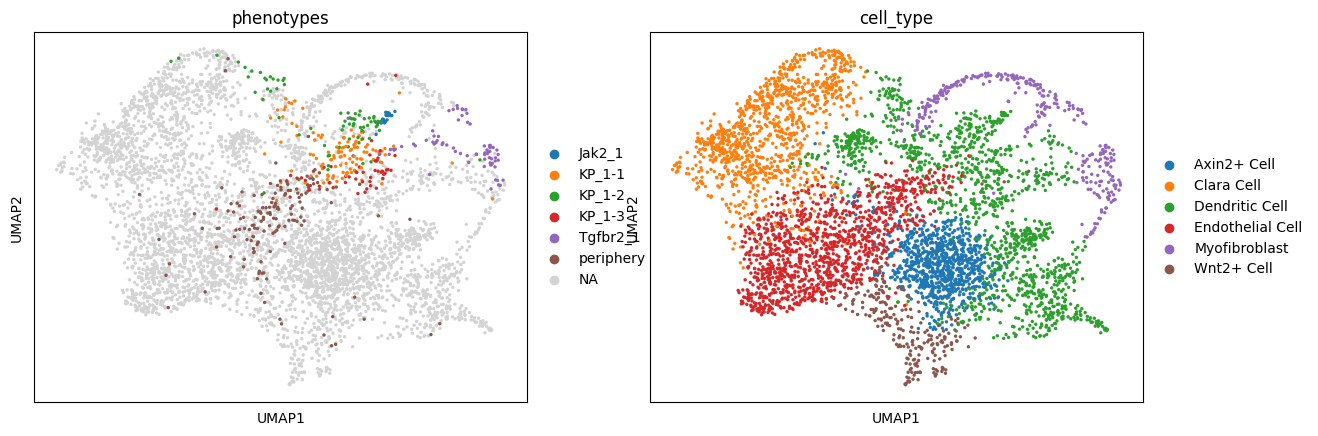

In [ ]:
sc.pl.umap(adata, color = ['phenotypes', 'cell_type'])

We will isolate tumor spots that are catalogued as 'excluded tumors', are enriched for DC infiltration but are untreated - so that means KP_1-2 that are labeled "Dendritic Cell" based on `cell_type`

Selected spots: 65
phenotypes in subset: ['KP_1-2']
cell types in subset: ['Dendritic Cell']


/tmp/ipython-input-2192773670.py:16: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color=["phenotypes"], title=["All phenotypes"])


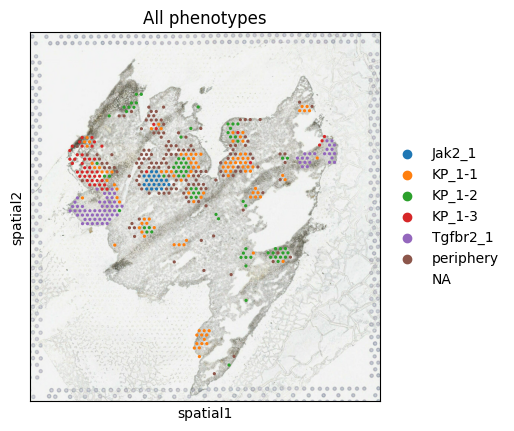

/tmp/ipython-input-2192773670.py:17: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_kp12_dc, color=["cell_type"], title=["KP_1-2 • Dendritic Cell only"])


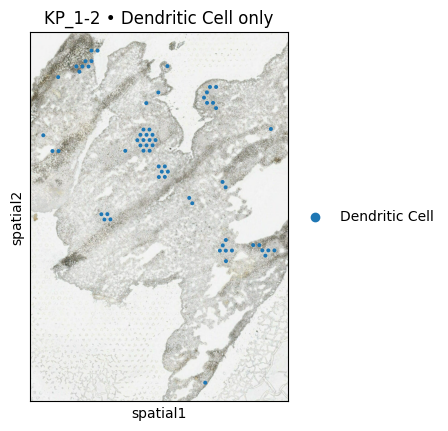

In [20]:
# Safety: work on copies of the two columns as lowercase strings (handles categories, NaNs, stray spaces)
phenos = adata.obs["phenotypes"].astype(str).str.strip()
ctypes = adata.obs["cell_type"].astype(str).str.strip()

# --- Exact match version (recommended if labels are clean) ---
mask_exact = (phenos == "KP_1-2") & (ctypes == "Dendritic Cell")
adata_kp12_dc = adata[mask_exact].copy()

print("Selected spots:", adata_kp12_dc.n_obs)

# Quick sanity checks
print("phenotypes in subset:", adata_kp12_dc.obs["phenotypes"].unique().tolist())
print("cell types in subset:", adata_kp12_dc.obs["cell_type"].unique().tolist())

# Optional: visualize the selected spots on the slide
sc.pl.spatial(adata, color=["phenotypes"], title=["All phenotypes"])
sc.pl.spatial(adata_kp12_dc, color=["cell_type"], title=["KP_1-2 • Dendritic Cell only"])

# --- If your labels vary a bit (e.g., “dendritic cell”, “Dendritic cells”) use a tolerant mask ---
mask_loose = (phenos == "KP_1-2") & (ctypes.str.lower().str.contains(r"\bdendritic\b"))
adata_kp12_dc_loose = adata[mask_loose].copy()


We calculate 2000 HVGs in a joint adata that contains Tgfbr2_1 and KP_1-2, both from DC infliltrated tumor sites

In [21]:
# 1. Subset to DCs in KP_1-2 or Tgfbr2_1
is_dc = adata.obs["cell_type"] == "Dendritic Cell"
is_pheno = adata.obs["phenotypes"].isin(["KP_1-2", "Tgfbr2_1"])
adata_dc_joint = adata[is_dc & is_pheno].copy()

# 2. Normalize + log-transform
sc.pp.normalize_total(adata_dc_joint, target_sum=1e4)
sc.pp.log1p(adata_dc_joint)

# 3. HVG calculation (Seurat v3 flavor is robust)
sc.pp.highly_variable_genes(adata_dc_joint, n_top_genes=2000)

# Save mask
hvg_mask = adata_dc_joint.var["highly_variable"].copy()

print("HVGs detected:", hvg_mask.sum())

HVGs detected: 2000


We now downsample to the 2000 HVGs plus the Tgfbr2 gene that is not in HVGs but we need it for the ensuing digital KO simulation.

In [22]:
# 4. Apply HVG mask to untreated tumor DCs (KP_1-2)
# Force-include Tgfbr2 in the mask
hvg_mask_forced = hvg_mask.copy()

if "Tgfbr2" in adata.var_names:
    hvg_mask_forced.loc["Tgfbr2"] = True
else:
    print("⚠️ Warning: 'Tgfbr2' not found in adata.var_names")

# Check how many genes now
print("Number of selected genes (HVGs + forced Tgfbr2):", hvg_mask_forced.sum())

adata_kp12_dc_hvg = adata_kp12_dc[:, hvg_mask_forced].copy()

# 5. KO DC object (Tgfbr2_1 only), subset to same HVGs
adata_tgfbr2 = adata[is_dc & (adata.obs["phenotypes"] == "Tgfbr2_1")].copy()
adata_tgfbr2_hvg = adata_tgfbr2[:, hvg_mask_forced].copy()

# Optional: annotate the joint mask for traceability
adata_kp12_dc_hvg.var["highly_variable_joint"] = hvg_mask_forced.loc[adata_kp12_dc_hvg.var_names].values
adata_tgfbr2_hvg.var["highly_variable_joint"] = hvg_mask_forced.loc[adata_tgfbr2_hvg.var_names].values


Number of selected genes (HVGs + forced Tgfbr2): 2001


In [23]:
adata_tgfbr2_hvg

AnnData object with n_obs × n_vars = 25 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod', 'phenotypes_mod2', 'phenotypes_sub'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'phenotypes_colors', 'kmeans_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connecti

In [24]:
adata_kp12_dc_hvg

AnnData object with n_obs × n_vars = 65 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod', 'phenotypes_mod2', 'phenotypes_sub'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'phenotypes_colors', 'kmeans_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'

Now, let's calculate differentially expressed genes between the two regions of interest to discern what is the molecular footprint of knocking-out Tgfbr2 in this part of the lung TME

In [ ]:
# 1. Concatenate both HVG-filtered objects
adata_de = adata_kp12_dc_hvg.concatenate(
    adata_tgfbr2_hvg,
    batch_key="condition",
    batch_categories=["KP_1-2_DC", "Tgfbr2_1_DC"]
)

print(adata_de)

# 2. Ensure condition labels are in .obs
print(adata_de.obs["condition"].value_counts())

# 3. Run DE analysis
sc.tl.rank_genes_groups(
    adata_de,
    groupby="condition",
    reference="KP_1-2_DC",   # untreated as baseline
    method="wilcoxon"
)

# 4. Extract DE results for KO vs untreated
df_de = sc.get.rank_genes_groups_df(adata_de, group="Tgfbr2_1_DC")

# 5. Save or inspect
# df_de.to_csv("DE_Tgfbr2_vs_KP12_DC.csv", index=False)
print(df_de.head())

AnnData object with n_obs × n_vars = 90 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod', 'condition'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'raw_count'
KP_1-2_DC      65
Tgfbr2_1_DC    25
Name: condition, dtype: int64
   names    scores  logfoldchanges         pvals     pvals_adj
0    Eln  7.076026        2.380573  1.483468e-12  1.327417e-09
1    Mif  7.021976        2.0478

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


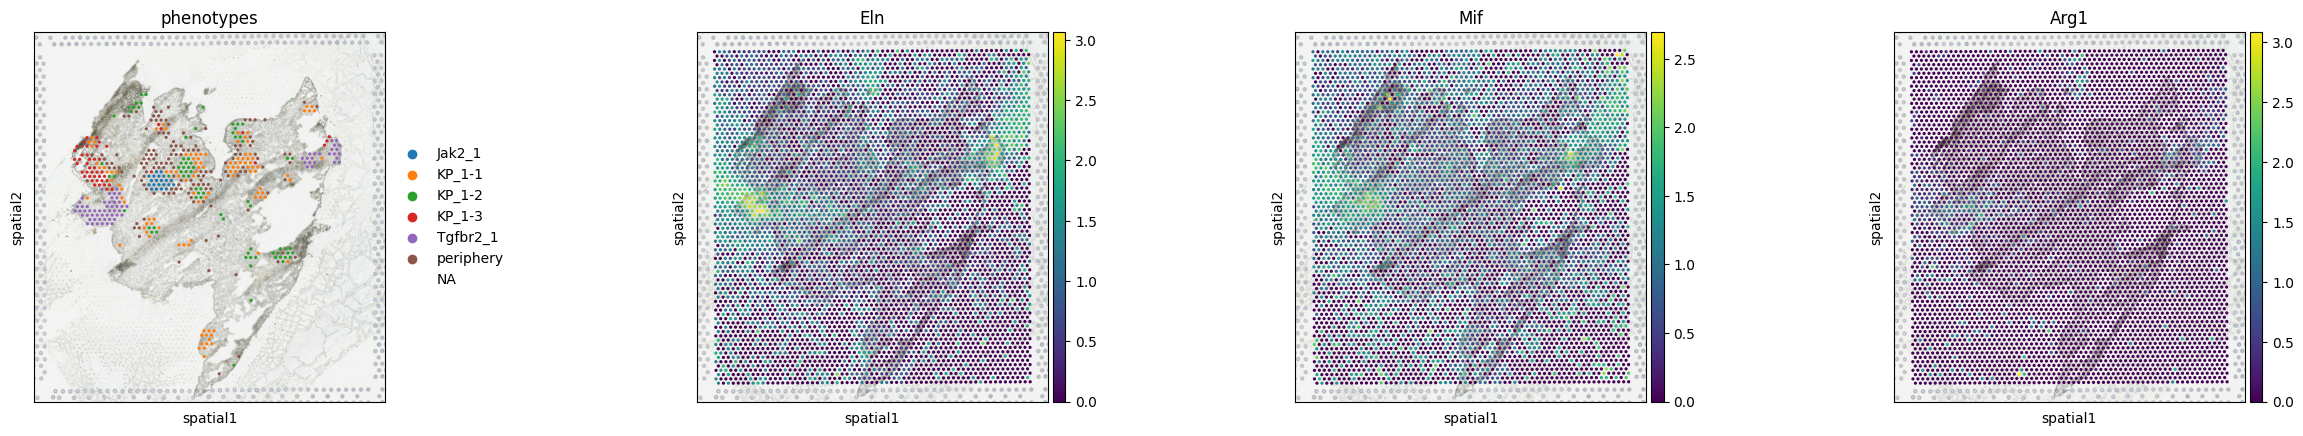

In [ ]:
sc.pl.spatial(adata, color=["phenotypes", "Eln", "Mif", "Arg1"])

In [ ]:
df_de.head(50)

names    scores  logfoldchanges         pvals     pvals_adj
0        Eln  7.076026        2.380573  1.483468e-12  1.327417e-09
1        Mif  7.021976        2.047899  2.187515e-12  1.327417e-09
2      Sparc  7.012968        1.184572  2.333147e-12  1.327417e-09
3       Arg1  6.994951        4.586595  2.653508e-12  1.327417e-09
4       Tpi1  6.940902        2.042015  3.896053e-12  1.559201e-09
5        Pkm  6.913877        1.670880  4.715852e-12  1.572737e-09
6    Fam162a  6.841810        2.312746  7.819865e-12  2.235364e-09
7      Pgam1  6.814785        1.798826  9.440466e-12  2.361297e-09
8   Serpine2  6.724702        1.876321  1.759519e-11  3.745339e-09
9       Ldha  6.715694        1.477003  1.871734e-11  3.745339e-09
10     Timp1  6.688669        2.432226  2.252095e-11  4.096766e-09
11       Tnc  6.652636        3.247481  2.878901e-11  4.800568e-09
12     Aldoa  6.598586        1.489470  4.150980e-11  6.389316e-09
13        F3  6.553545        1.596225  5.618724e-11  8.030762e-09
14      Pgk1  6.481478        1.823653  9.082849e-11  1.211652e-08
15  Serpine1  6.431932        3.732319  1.259920e-10  1.575687e-08
16     Bnip3  6.359866        3.429841  2.019302e-10  2.376837e-08
17    Higd1a  6.274287        1.441653  3.512406e-10  3.699118e-08
18       Bsg  6.247262        1.451429  4.177105e-10  4.179193e-08
19      Pfkl  6.193212        2.361388  5.895035e-10  5.203995e-08
20      Gpi1  6.184204        1.406326  6.241673e-10  5.203995e-08
21    Cxcl14  6.184204        1.706410  6.241673e-10  5.203995e-08
22     Mmp12  6.139162        2.377803  8.295786e-10  6.639947e-08
23     Gapdh  6.121146        1.456343  9.290500e-10  7.150112e-08
24      Plat  6.022054        1.623733  1.722173e-09  1.276321e-07
25     Ndrg1  6.013046        2.446932  1.820695e-09  1.301147e-07
26    Slc2a1  5.986021        2.095775  2.150367e-09  1.483753e-07
27    Lgals1  5.868913        1.180200  4.386618e-09  2.831491e-07
28     P4ha1  5.855401        2.183707  4.758620e-09  2.975625e-07
29     Pebp1  5.832880        1.046286  5.447886e-09  3.303400e-07
30   Slc16a3  5.765317        2.453291  8.150433e-09  4.659719e-07
31     Ero1l  5.747301        2.451101  9.067936e-09  5.040261e-07
32    Col1a1  5.733788        1.478754  9.821192e-09  5.311407e-07
33       Lox  5.571639        2.248516  2.523543e-08  1.174328e-06
34    Col1a2  5.517589        1.122006  3.436823e-08  1.562973e-06
35       Mt1  5.499572        1.375973  3.807137e-08  1.692907e-06
36    Col8a1  5.355439        3.014458  8.534879e-08  3.633679e-06
37     Timp3  5.355439        1.268550  8.534879e-08  3.633679e-06
38       Mt2  5.337423        1.572189  9.427707e-08  3.849968e-06
39      Eno1  5.251844        1.565907  1.505842e-07  5.685262e-06
40      Eno3  5.238331        3.096109  1.620350e-07  6.004296e-06
41     Thbs1  5.229323        1.223662  1.701319e-07  6.189708e-06
42      Plk2  5.215811        1.873395  1.830152e-07  6.539524e-06
43       Mgp  5.103207        0.750343  3.339459e-07  1.172326e-05
44      Krt8  5.094198        0.727981  3.502199e-07  1.208259e-05
45     Hspg2  5.040149        1.404341  4.651707e-07  1.577638e-05
46    Igfbp3  5.022132        1.581478  5.110107e-07  1.676282e-05
47   Col15a1  5.022132        1.764755  5.110107e-07  1.676282e-05
48     P4ha2  4.981595        2.374576  6.306247e-07  1.971687e-05
49    Col5a2  4.923040        1.613172  8.520980e-07  2.583406e-05

Pathway enrichment for the top 50 genes based on pvalue is here: https://maayanlab.cloud/Enrichr/enrich?dataset=cbee3d5f380664e470b00ca5a6f537a6

In [ ]:
df_de.to_csv("DE_Tgfbr2_vs_KP12_DC.csv", index=False)

In [ ]:
adata_kp12_dc_hvg.write_h5ad("KP1_2_hvg.h5ad")

In [ ]:
adata_tgfbr2_hvg.write_h5ad("tgfbr2_1_hvg.h5ad")

In [ ]:
X = adata_kp12_dc.X.toarray() if hasattr(adata_kp12_dc.X, "toarray") else adata_kp12_dc.X
X = X.astype(np.float32)  # Ensure dtype is float32
adata_kp12_dc.X = X
print("dtype:", X.dtype)
print("min/max:", X.min(), "/", X.max())
print("mean:", X.mean(), " std:", X.std())
print("zero fraction:", np.mean(X == 0))

dtype: float32
min/max: 0.0 / 6.0147715
mean: 0.07844183  std: 0.24456114
zero fraction: 0.7937616287518731


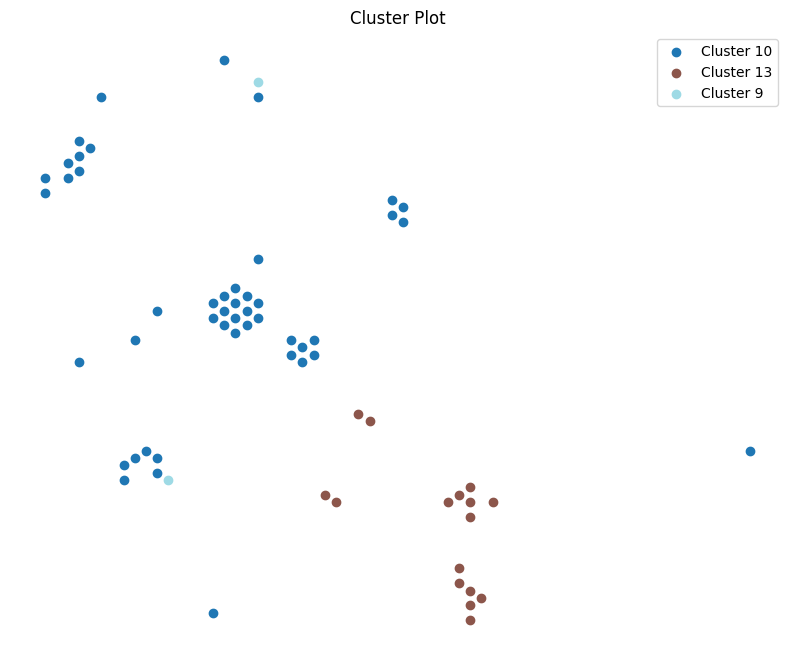

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create coordinate array
coord = np.array((list(adata_kp12_dc.obs['array_row'].astype('int')),
                  list(adata_kp12_dc.obs['array_col'].astype('int')))).T

united_clus = adata_kp12_dc.obs['clusters']

# Ensure cluster labels are strings or integers
unique_predicted_clusters = np.unique(united_clus)

# Generate a color map for clusters
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_predicted_clusters)))
color_dict = {clus_id: colors[idx] for idx, clus_id in enumerate(unique_predicted_clusters)}

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the cluster scatter plot
for clus_id in unique_predicted_clusters:
    mask = united_clus == clus_id
    ax.scatter(
        adata_kp12_dc.obs['array_row'][mask],
        adata_kp12_dc.obs['array_col'][mask],
        color=color_dict[clus_id],
        label=f"Cluster {clus_id}"
    )

ax.axis('off')
ax.legend()
ax.invert_yaxis()
ax.set_title("Cluster Plot")


plt.show()


In [ ]:
class Params:
    def __init__(self):
        self.knn_distanceType = 'euclidean'
        self.k = 15
        self.using_mask = False

params = Params()

In [ ]:
def sparse_mx_to_torch_sparse_tensor(scipy_matrix):
    """Convert a scipy sparse matrix to a PyTorch sparse tensor."""
    # Ensure it's in the correct format (COO format)
    scipy_matrix = scipy_matrix.tocoo()

    # Get row, column, and data from the COO matrix
    row = torch.LongTensor(scipy_matrix.row)
    col = torch.LongTensor(scipy_matrix.col)
    data = torch.FloatTensor(scipy_matrix.data)

    # Create a sparse tensor in PyTorch
    sparse_tensor = torch.sparse.FloatTensor(torch.stack([row, col]), data, torch.Size(scipy_matrix.shape))

    return sparse_tensor

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return adj_normalized, sparse_mx_to_torch_sparse_tensor(adj_normalized)

def edgeList2edgeDict(edgeList, nodesize):
    graphdict = {}
    tdict = {}
    for edge in edgeList:
        end1 = edge[0]
        end2 = edge[1]
        tdict[end1] = ""
        tdict[end2] = ""
        if end1 in graphdict:
            tmplist = graphdict[end1]
        else:
            tmplist = []
        tmplist.append(end2)
        graphdict[end1] = tmplist

    # check and get full matrix
    for i in range(nodesize):
        if i not in tdict:
            graphdict[i] = []

    return graphdict

def graph_computing(adj_coo, cell_num, params):
    edgeList = []
    for node_idx in range(cell_num):
        tmp = adj_coo[node_idx, :].reshape(1, -1)
        distMat = distance.cdist(tmp, adj_coo, params.knn_distanceType)
        res = distMat.argsort()[:params.k + 1]
        tmpdist = distMat[0, res[0][1:params.k + 1]]
        boundary = np.mean(tmpdist) + np.std(tmpdist)
        for j in np.arange(1, params.k + 1):
            if distMat[0, res[0][j]] <= boundary:
                weight = 1.0
            else:
                weight = 0.0
            edgeList.append((node_idx, res[0][j], weight))

    return edgeList

def graph_construction(adj_coo, cell_N, params):
    adata_Adj = graph_computing(adj_coo, cell_N, params)
    graphdict = edgeList2edgeDict(adata_Adj, cell_N)
    adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))

    # Store original adjacency matrix (without diagonal entries) for later
    adj_m1 = adj_org
    adj_m1 = adj_m1 - sp.dia_matrix((adj_m1.diagonal()[np.newaxis, :], [0]), shape=adj_m1.shape)
    adj_m1.eliminate_zeros()

    # Some preprocessing
    adj_norm_write, adj_norm_m1 = preprocess_graph(adj_m1)
    adj_label_m1 = adj_m1 + sp.eye(adj_m1.shape[0])
    adj_label_m1 = torch.FloatTensor(adj_label_m1.toarray())
    norm_m1 = adj_m1.shape[0] * adj_m1.shape[0] / float((adj_m1.shape[0] * adj_m1.shape[0] - adj_m1.sum()) * 2)

    graph_dict = {
        "adj_org": adj_org,
        "adj_norm": adj_norm_m1,
        "adj_label": adj_label_m1,
        "norm_value": norm_m1
    }
    # mask is binary matrix for semi-supervised/multi-dataset (1-valid edge, 0-unknown edge)
    if params.using_mask is True:
        graph_dict["adj_mask"] = torch.ones(cell_N, cell_N)
    return graph_dict, adj_norm_write

In [ ]:
graph_dict, adj_norm_write = graph_construction(adata_kp12_dc.obsm['spatial'], adata_kp12_dc.shape[0], params)

### save niche_mrna
adj_label = graph_dict['adj_label'].cpu().detach().numpy()
spatial_coo=adata_kp12_dc.obsm['spatial']
niche_mrna=np.zeros(adata_kp12_dc.X.shape)
for ind,i in enumerate(adj_label):
    distMat = distance.cdist(spatial_coo[ind,:].reshape(1,-1), spatial_coo[i.astype(bool),:], metric='euclidean')
    distMat[distMat>0]=1/distMat[distMat>0]
    distMat_normed = distMat / sum(sum(distMat))
    niche_mrna[ind, :] = distMat_normed.dot(adata_kp12_dc.X[i.astype(bool), :])
### save niche_mrna
niche_mrna2=pd.DataFrame(niche_mrna.T,index=adata_kp12_dc.var_names,columns=adata_kp12_dc.obs_names)
niche_mrna2.to_csv('../Data/perturbmap_stomicsdb/niche_kp12_dc.csv')

In [ ]:
df = niche_mrna2

In [ ]:
# df = pd.read_csv("../Data/visium/niche_mrna_VisiumRNABC.csv", index_col=0)  # Assuming the first column is gene/sample names
df = df.T

In [ ]:
adata_niche = anndata.AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [ ]:
cell_metadata = adata_kp12_dc.obs  # Metadata for samples/cells
gene_metadata = adata_kp12_dc.var  # Metadata for genes

In [ ]:
adata_niche.obs = cell_metadata  # Assign metadata to adata.obs
adata_niche.var = gene_metadata

In [ ]:
X = adata_niche.X.toarray() if hasattr(adata_niche.X, "toarray") else adata_niche.X
X = X.astype(np.float32)  # Ensure dtype is float64
adata_niche.X = X
print("dtype:", X.dtype)
print("min/max:", X.min(), "/", X.max())
print("mean:", X.mean(), " std:", X.std())
print("zero fraction:", np.mean(X == 0))

dtype: float32
min/max: 0.0 / 5.408764
mean: 0.078419566  std: 0.22952281
zero fraction: 0.579304216487158


In [ ]:
adata_niche

AnnData object with n_obs × n_vars = 65 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [ ]:
adata_niche.write_h5ad('niche_mod_KP1_2.h5ad')

In [ ]:
niche =  sc.read_h5ad('../Data/perturbmap_stomicsdb/niche_mod_KP1_2.h5ad')
niche

AnnData object with n_obs × n_vars = 65 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [ ]:
KP1_2_hvg

In [ ]:
rna =  sc.read_h5ad('../Data/perturbmap_stomicsdb/KP1_2_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 65 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_clusters', 'hvg', 'kmeans_colors', 'leiden', 'neighbors', 'pca', 'phenotypes_colors', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distanc

In [ ]:
# RNA (target) object with exactly 2001 genes
# rna = adata_kp12_dc_hvg          # or whatever your RNA HVG object variable is
nch = niche                      # your full-gene niche AnnData

# 1) Align cells (rows). If they’re already identical and in order, this is a no-op.
if not np.array_equal(nch.obs_names.values, rna.obs_names.values):
    # Reindex niche to RNA’s cells (will error if any cell missing)
    nch = nch[rna.obs_names].copy()

# 2) Get target gene order (2001 genes from RNA object)
target_genes = rna.var_names

# 3) Check for missing genes in niche
missing = [g for g in target_genes if g not in nch.var_names]
if missing:
    raise ValueError(f"{len(missing)} genes missing in niche.var_names (e.g. {missing[:5]}). "
                     "Make sure gene naming matches (case/suffixes).")

# 4) Subset niche to the exact 2001 genes, preserving order
niche_hvg = nch[:, target_genes].copy()

# 5) (Optional) annotate provenance
niche_hvg.uns["modality"] = "niche"
niche_hvg.uns["gene_set"] = "2001 genes aligned to RNA HVG (incl. forced Tgfbr2)"

In [ ]:
niche_hvg

AnnData object with n_obs × n_vars = 65 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'modality', 'gene_set'

In [ ]:
rna

AnnData object with n_obs × n_vars = 65 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_clusters', 'hvg', 'kmeans_colors', 'leiden', 'neighbors', 'pca', 'phenotypes_colors', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distanc

### Compare RNA and niche

In [ ]:
# Gene-wise correlation between RNA and niche

X_rna   = rna.X.A if hasattr(rna.X, "A") else np.asarray(rna.X)
X_niche = niche_hvg.X.A if hasattr(niche_hvg.X, "A") else np.asarray(niche_hvg.X)

cors = [np.corrcoef(X_rna[:, i], X_niche[:, i])[0,1] for i in range(X_rna.shape[1])]
df_gene_corr = pd.DataFrame({"gene": rna.var_names, "rna_niche_corr": cors})
df_gene_corr = df_gene_corr.sort_values("rna_niche_corr")

print("Most different genes (low RNA–niche correlation):")
print(df_gene_corr.head(15))


Most different genes (low RNA–niche correlation):
         gene  rna_niche_corr
1245   Rangrf       -0.511895
1243    Cox10       -0.502948
1952    Sept6       -0.487482
1286    Utp18       -0.463704
1725   Kcnj15       -0.457542
1702    Adprh       -0.453615
33      Sp110       -0.452220
1720    Scaf4       -0.451358
1682  Igf2bp2       -0.447834
1045     Mcam       -0.442343
1761     Sik1       -0.437763
588     Lrwd1       -0.436478
222      Esf1       -0.433969
1177     Vezt       -0.432736
1864    Psmg2       -0.428966


invalid value encountered in divide


In [ ]:
# Variance comparison

rna_var   = X_rna.var(axis=0)
niche_var = X_niche.var(axis=0)

df_var = pd.DataFrame({
    "gene": rna.var_names,
    "rna_var": rna_var,
    "niche_var": niche_var,
    "delta_var": niche_var - rna_var
}).sort_values("delta_var")

print("Genes with largest variance drop (niche smoother):")
print(df_var.head(10))
print("Genes with variance increase (niche highlights gradients):")
print(df_var.tail(10))

Genes with largest variance drop (niche smoother):
         gene   rna_var  niche_var  delta_var
1418   Ighg2c  2.245846   1.230024  -1.015822
1419   Ighg2b  1.512621   0.843885  -0.668735
1416     Igha  0.979827   0.445158  -0.534670
1420    Ighg1  1.370434   0.845421  -0.525012
664      Igkc  1.307952   0.789805  -0.518147
528    Jchain  1.041855   0.549135  -0.492720
1760     Tff1  0.443014   0.063626  -0.379389
1791  Gm42418  0.471454   0.113225  -0.358229
861    Hbb-bs  0.409202   0.063065  -0.346137
1221  Scgb3a1  0.557449   0.237380  -0.320069
Genes with variance increase (niche highlights gradients):
               gene  rna_var  niche_var  delta_var
296         Gm37855      0.0        0.0        0.0
298          Lrrc71      0.0        0.0        0.0
305           Lenep      0.0        0.0        0.0
1849         Gm5820      0.0        0.0        0.0
932   2500002B13Rik      0.0        0.0        0.0
1845        Pcdhgb4      0.0        0.0        0.0
715           Pianp      0.

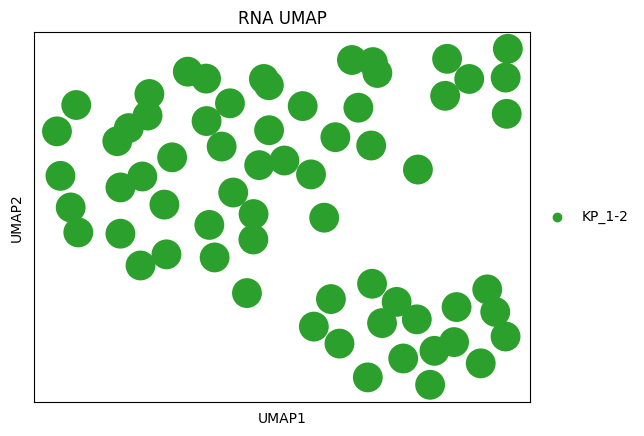

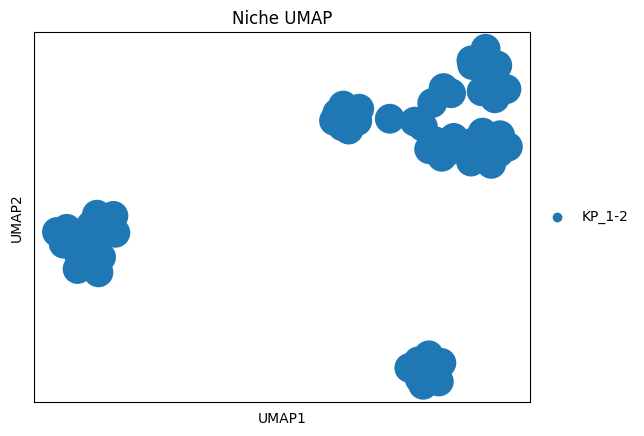

In [ ]:
# Embedding

import scanpy as sc

# RNA UMAP
sc.tl.pca(rna, use_highly_variable=False)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.pl.umap(rna, color="phenotypes", title="RNA UMAP")

# Niche UMAP
niche_tmp = niche_hvg.copy()
sc.tl.pca(niche_tmp, use_highly_variable=False)
sc.pp.neighbors(niche_tmp)
sc.tl.umap(niche_tmp)
sc.pl.umap(niche_tmp, color="phenotypes", title="Niche UMAP")



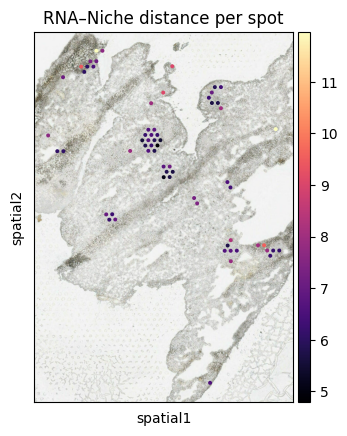

In [ ]:
# Spot-wise distance between RNA and niche
# how far is the niche profile from its raw RNA profile


from numpy.linalg import norm

dists = norm(X_rna - X_niche, axis=1)
rna.obs["rna_niche_distance"] = dists

sc.pl.spatial(rna, color="rna_niche_distance", cmap="magma", title="RNA–Niche distance per spot")


In [ ]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors
import scanpy as sc

# 1. Select source AnnData and its spatial coords
adata_source = adatas_all[0]
coords = adata_source.obsm['spatial']
n = coords.shape[0]
k = 15  # smoothing neighbors

# 2. Build kNN graph edges
nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(coords)
_, idxs = nbrs.kneighbors(coords)
rows = np.repeat(np.arange(n), k)
cols = idxs[:, 1:].flatten()  # drop self
A = sp.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(n, n))

# 3. Add self-loops and normalize
A_hat = A + sp.eye(n)
deg = np.array(A_hat.sum(1)).flatten()
D_inv_sqrt = sp.diags(1.0 / np.sqrt(deg))
A_norm = D_inv_sqrt.dot(A_hat).dot(D_inv_sqrt).tocsr()

# 4. Compute smoothed expression
X_raw = adata_source.X.toarray() if sp.issparse(adata_source.X) else adata_source.X.copy()
X_niche = A_norm.dot(X_raw)

# 5. Create a new AnnData for the niche-smoothed data
adata_niche = sc.AnnData(
    X = X_niche,
    obs = adata_source.obs.copy(),
    var = adata_source.var.copy(),
    obsm = adata_source.obsm.copy(),
    uns = adata_source.uns.copy(),
    layers = {**adata_source.layers}  # keep other layers if desired
)

# 6. Optionally, store raw counts in the new object
adata_niche.layers["raw"] = X_raw

# Confirm
print(f"adata_niche created: {adata_niche.n_obs} cells, {adata_niche.n_vars} genes")


adata_niche created: 4169 cells, 500 genes


X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [ ]:
# import numpy as np
# import scipy.sparse as sp
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler

# # 1) Source AnnData
# adata_source = adatas_all[0]
# coords       = adata_source.obsm['spatial']
# n            = coords.shape[0]
# k            = 15   # or your chosen k

# # 2) Build binary kNN graph (exclude self, then add loops)
# nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(coords)
# _, idxs = nbrs.kneighbors(coords)
# rows = np.repeat(np.arange(n), k)
# cols = idxs[:, 1:].flatten()
# A = sp.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(n, n))

# # 3) Symmetric normalization with self-loops
# A_hat     = A + sp.eye(n)
# deg       = np.array(A_hat.sum(1)).flatten()
# D_inv_srt = sp.diags(1.0 / np.sqrt(deg))
# A_norm    = D_inv_srt.dot(A_hat).dot(D_inv_srt).tocsr()

# # 4) Smooth the data
# X_raw     = adata_source.X.toarray() if sp.issparse(adata_source.X) else adata_source.X.copy()
# X_niche   = A_norm.dot(X_raw)

# # 5) Z-score each gene (column) to mean=0, var=1
# scaler    = StandardScaler(with_mean=True, with_std=True)
# X_niche_z = scaler.fit_transform(X_niche)

# # 6) Build a new AnnData for niche
# adata_niche = adata_source.copy()
# adata_niche.layers["raw"] = X_raw
# adata_niche.X             = X_niche_z

# print(f"adata_niche ready: var per gene ≈ {adata_niche.X.var(axis=0).mean():.3f}")  # should be ≈1.0


adata_niche ready: var per gene ≈ 1.000


Top 10 genes by mean absolute difference:
         gene  mean_abs_diff
1418   Ighg2c       0.750402
664      Igkc       0.579647
528    Jchain       0.555912
1760     Tff1       0.546448
1416     Igha       0.540958
1419   Ighg2b       0.523388
1791  Gm42418       0.498236
861    Hbb-bs       0.469753
1420    Ighg1       0.469473
1221  Scgb3a1       0.459851


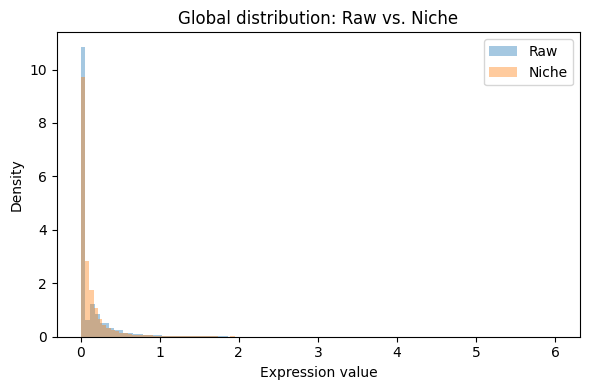

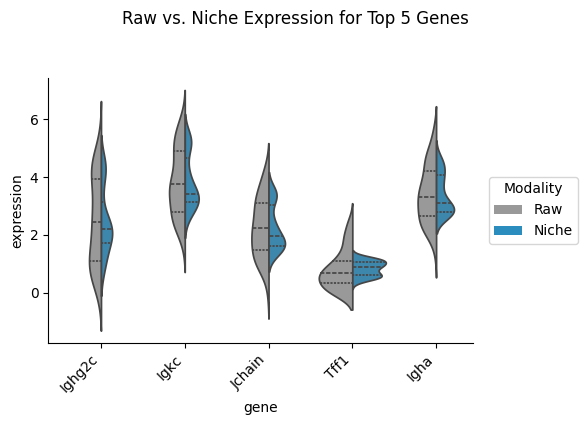

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from anndata import AnnData

# -----------------------------------------------------------------------------
# 1. Unpack your loaded AnnData objects
#    Assuming adatas_all = [adata_rna, adata_protein, adata_niche_rna]
# adata_rna, _, adata_niche = adatas_all

# -----------------------------------------------------------------------------
# 2. Verify identical gene ordering
assert np.all(rna.var_names == niche_hvg.var_names), "Gene ordering mismatch!"

# -----------------------------------------------------------------------------
# 3. Compute per-gene mean absolute difference
raw_mat   = rna.X.toarray() if hasattr(rna.X, "toarray") else rna.X
niche_mat = niche_hvg.X

delta = np.abs(raw_mat - niche_mat).mean(axis=0)  # shape = (n_genes,)
df_delta = pd.DataFrame({
    'gene': rna.var_names,
    'mean_abs_diff': delta
}).sort_values('mean_abs_diff', ascending=False)

print("Top 10 genes by mean absolute difference:")
print(df_delta.head(10))

# -----------------------------------------------------------------------------
# 4. Global histogram: raw vs. niche (all entries)
plt.figure(figsize=(6,4))
plt.hist(raw_mat.flatten(),   bins=100, alpha=0.4, label='Raw',   density=True)
plt.hist(niche_mat.flatten(), bins=100, alpha=0.4, label='Niche', density=True)
plt.xlabel('Expression value')
plt.ylabel('Density')
plt.title('Global distribution: Raw vs. Niche')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 5. Build tidy DataFrame for top genes
top5 = df_delta.head(5)['gene'].tolist()

# extract matrices for just those genes
raw_top   = rna[:, top5].X.toarray() if hasattr(rna.X, "toarray") else rna[:, top5].X
niche_top = niche_hvg[:, top5].X

dfs = []
for modality, mat in [("Raw", raw_top), ("Niche", niche_top)]:
    df = pd.DataFrame(mat, columns=top5, index=rna.obs_names)
    df = df.reset_index().melt(id_vars="index", var_name="gene", value_name="expression")
    df["modality"] = modality
    dfs.append(df)

df_tidy = pd.concat(dfs, ignore_index=True)
df_tidy.rename(columns={"index": "cell"}, inplace=True)

# -----------------------------------------------------------------------------
# 6. Split violin plot via Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Re‐draw the plot without Seaborn’s legend
g = sns.catplot(
    data=df_tidy,
    x="gene", y="expression", hue="modality",
    kind="violin",
    split=True,
    inner="quartile",
    height=4, aspect=1.5,
    palette=["#999999","#2b8cbe"],
    legend=False      # turn off Seaborn legend
)

# Rotate x tick labels
g.set_xticklabels(rotation=45, ha="right")
g.fig.suptitle("Raw vs. Niche Expression for Top 5 Genes", y=1.05)

# Now add a Matplotlib legend on the right
ax = g.axes[0,0]
for modality, color in zip(["Raw","Niche"], ["#999999","#2b8cbe"]):
    ax.bar(0, 0, color=color, label=modality)  # dummy artists

ax.legend(
    title="Modality",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()



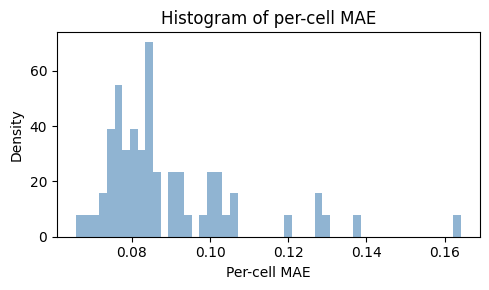

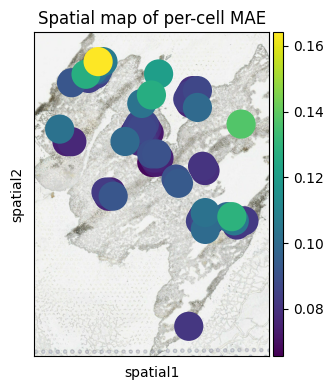

Top 10 genes by mean_abs_diff:
         gene  mean_abs_diff
1418   Ighg2c       0.750402
664      Igkc       0.579647
528    Jchain       0.555912
1760     Tff1       0.546448
1416     Igha       0.540958
1419   Ighg2b       0.523388
1791  Gm42418       0.498236
861    Hbb-bs       0.469753
1420    Ighg1       0.469473
1221  Scgb3a1       0.459851


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from anndata import AnnData

# -----------------------------------------------------------------------------
# Assume you have:
#   rna        : AnnData with raw expression and .obsm['spatial']
#   niche_hvg  : AnnData with niche expression in .X, same obs/var as rna
# -----------------------------------------------------------------------------

# 1) Convert to dense arrays
raw_mat   = rna.X.toarray() if hasattr(rna.X, "toarray") else rna.X
niche_mat = niche_hvg.X.toarray() if hasattr(niche_hvg.X, "toarray") else niche_hvg.X

# 2) Compute per-cell mean absolute error (MAE)
cell_diff = np.mean(np.abs(raw_mat - niche_mat), axis=1)

# 3) Add MAE to rna.obs
rna.obs['mae'] = cell_diff

# -----------------------------------------------------------------------------
# 4) Global histogram of MAE
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(cell_diff, bins=50, density=True, alpha=0.6, color='steelblue')
ax.set_xlabel('Per-cell MAE')
ax.set_ylabel('Density')
ax.set_title('Histogram of per-cell MAE')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 5) Violin of MAE by batch and by leiden
for group in ['batch', 'leiden']:
    if group in rna.obs:
        fig, ax = plt.subplots(figsize=(4,3))
        sc.pl.violin(
            rna,
            keys='mae',
            groupby=group,
            use_raw=False,
            jitter=0.4,
            stripplot=False,
            size=1,
            log=False,
            multi_panel=False,
            ax=ax,
            density_norm='width'
        )
        ax.set_title(f'MAE by {group}')
        plt.tight_layout()
        plt.show()

# -----------------------------------------------------------------------------
# 6) Spatial scatter of MAE
fig, ax = plt.subplots(figsize=(4,4))
sc.pl.spatial(
    rna,
    color='mae',
    spot_size=300,
    cmap='viridis',
    title='Spatial map of per-cell MAE',
    show=False,
    ax=ax
)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7) Top genes by MAE difference
delta = np.mean(np.abs(raw_mat - niche_mat), axis=0)
df_delta = pd.DataFrame({
    'gene': rna.var_names,
    'mean_abs_diff': delta
}).sort_values('mean_abs_diff', ascending=False)

print("Top 10 genes by mean_abs_diff:")
print(df_delta.head(10))


In [ ]:
# adata_niche.write("../Data/visium/niche_mrna_VisiumRNABC.h5ad")

Next, we will prepare train/test datasets for the 2 modalities:

In [ ]:
adata_rna = rna
adata_niche = niche_hvg



# Define the split ratio
train_size = 0.8

# Get total number of observations (cells)
n_samples = adata_rnas.n_obs

# Generate indices
train_idx, test_idx = train_test_split(np.arange(n_samples), train_size=train_size, random_state=42)

# Split the AnnData object
adata_rna_train = adata_rna[train_idx].copy()
adata_rna_test = adata_rna[test_idx].copy()
adata_rna_train.write_h5ad('../Data/perturbmap_stomicsdb/adata_rna_train_perturbmap_KP2_1.h5ad')
adata_rna_test.write_h5ad('../Data/perturbmap_stomicsdb/adata_rna_test_perturbmap_KP2_1.h5ad')

# Split the AnnData object
adata_niche_train = adata_niche[train_idx].copy()
adata_niche_test = adata_niche[test_idx].copy()
adata_niche_train.write_h5ad('../Data/perturbmap_stomicsdb/adata_niche_rna_train_perturbmap_KP2_1.h5ad')
adata_niche_test.write_h5ad('../Data/perturbmap_stomicsdb/adata_niche_rna_test_perturbmap_KP2_1.h5ad')

# GenKI for digital KO

## Run in silico perturbation


In this section, we simulate a genetic perturbation that mimics a CRISPR Knock-Out (KO) experiment targeting one or more specific molecular entities. **GenKI**, a graph variational autoencoder, first reconstructs the underlying **Gene Regulatory Network (GRN)** from the data. It then performs an *in silico* knock-out by removing the selected target gene(s) from the network and quantifies the resulting changes using **Kullback–Leibler (KL) divergence** to identify which genes are most impacted by the perturbation.


In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import re

sc.settings.verbosity = 0

import GenKI as gk
from GenKI.preprocesing import build_adata
from GenKI.dataLoader import DataLoader
from GenKI.train import VGAE_trainer
from GenKI import utils

import stringdb
import networkx as nx

from scipy.sparse import csr_matrix
from scipy.sparse import issparse

/home/ggavriilidis/.conda/envs/unitednet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-14 08:56:50,080	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-14 08:56:50.193384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 08:56:50.200355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-14 08:56:50.208157: E external/local_xla/xla

We are going to target in silico Tgfbr2!

In [3]:
!pwd

/home/ggavriilidis/Mongoose


In [4]:
adata = build_adata("Data/perturbmap_stomicsdb/KP1_2_hvg.h5ad",
    uppercase=False)

adata

load counts from Data/perturbmap_stomicsdb/KP1_2_hvg.h5ad


AnnData object with n_obs × n_vars = 65 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod', 'phenotypes_mod2', 'phenotypes_sub'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count', 'norm'
    obsp: 'connectivities', '

In [ ]:
"Data/scMINER/consensus_network_ncol_sig.txt"

In [6]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix

# --- 1) Reload and fix header ---
df_raw = pd.read_csv("Data/scMINER/consensus_network_ncol_sig.txt", sep="\t", header=None)
df_raw.columns = df_raw.iloc[0].astype(str).str.strip()     # use first row as header
df = df_raw.iloc[1:].reset_index(drop=True)                 # drop that header row from data

# Optional: clean up whitespace in columns we care about
df["source"] = df["source"].astype(str).str.strip()
df["target"] = df["target"].astype(str).str.strip()
df["MI"] = pd.to_numeric(df["MI"], errors="coerce")

print("Columns:", df.columns.tolist())
print(df.head(3))


Columns: ['source', 'target', 'source.symbol', 'target.symbol', 'MI', 'pearson', 'spearman', 'slope', 'p.value']
0         source   target  source.symbol target.symbol      MI pearson  \
0  2310033P09Rik      Hk3  2310033P09Rik           Hk3  0.4351  0.4093   
1  2310033P09Rik   Man1b1  2310033P09Rik        Man1b1  0.4321  0.2943   
2  2310033P09Rik  N4bp2l2  2310033P09Rik       N4bp2l2  0.4029  0.2621   

0 spearman   slope p.value  
0   0.3092  0.3901   3e-04  
1   0.2244  0.6418  0.0104  
2   0.1385  0.4852  0.0231  


/tmp/ipykernel_155046/1493527760.py:6: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("Data/scMINER/consensus_network_ncol_sig.txt", sep="\t", header=None)


In [7]:
# --- 2) Keep the needed columns ---
edges = df[["source", "target", "MI"]].dropna().copy()
edges.rename(columns={"MI": "weight"}, inplace=True)

# --- 3) Create sparse adjacency (CSR) ---
genes = sorted(set(edges["source"]).union(edges["target"]))
g2i = {g: i for i, g in enumerate(genes)}

rows = edges["source"].map(g2i).to_numpy()
cols = edges["target"].map(g2i).to_numpy()
vals = edges["weight"].astype(float).to_numpy()

W = coo_matrix((vals, (rows, cols)), shape=(len(genes), len(genes))).tocsr()
W.eliminate_zeros(); W.sort_indices()

# --- 4) Save in GenKI-compatible .npz layout ---
def save_grn_npz(csr: csr_matrix, path: str):
    np.savez(path,
             data=csr.data,
             indices=csr.indices,
             indptr=csr.indptr,
             shape=np.array(csr.shape, dtype=np.int64))

save_grn_npz(W, "Consensus_GRN_MI.npz")
np.save("Consensus_GRN_MI_genes.npy", np.array(genes, dtype=object))

print("Saved:", W.shape, "nonzeros:", W.nnz)


Saved: (13443, 13443) nonzeros: 174686


In [12]:
!pwd

/home/ggavriilidis/Mongoose


In [8]:
# --- Optional: threshold on MI (keep top 15% by absolute MI) ---
thr = np.percentile(np.abs(vals), 85)
mask = np.abs(vals) >= thr

W_thr = coo_matrix((vals[mask], (rows[mask], cols[mask])),
                   shape=(len(genes), len(genes))).tocsr()
W_thr.eliminate_zeros(); W_thr.sort_indices()

save_grn_npz(W_thr, "Consensus_GRN_MI_top15pct.npz")
print("Thresholded nonzeros:", W_thr.nnz)


Thresholded nonzeros: 26264


In [16]:
# Assuming 'edges' has columns ['source', 'target', 'weight']
unique_genes = set(edges["source"]).union(set(edges["target"]))
print("Number of unique genes:", len(unique_genes))

# If you want the actual list:
unique_genes = sorted(unique_genes)
print(unique_genes[:20])  # preview first 20


Number of unique genes: 13443
['0610009B22Rik', '0610009E02Rik', '0610010F05Rik', '0610010K14Rik', '0610012G03Rik', '0610030E20Rik', '0610040B10Rik', '0610040J01Rik', '0710001A04Rik', '1110002E22Rik', '1110002L01Rik', '1110004F10Rik', '1110008P14Rik', '1110012L19Rik', '1110019D14Rik', '1110028F11Rik', '1110032A03Rik', '1110035H17Rik', '1110038B12Rik', '1110038F14Rik']


In [24]:
import numpy as np
from scipy.sparse import csr_matrix, save_npz

# If you still have W_thr (CSR) in memory, just do:
save_npz("Data/GRNs/Consensus_GRN_MI_top15pct.npz", W_thr)


In [25]:
from scipy.sparse import load_npz
W2 = load_npz("Data/GRNs/Consensus_GRN_MI_top15pct.npz")
print(W2.shape, W2.nnz)


(13443, 13443) 26264


In [19]:
!pwd

/home/ggavriilidis/Mongoose


In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, save_npz

# Assume edges has ["source", "target", "weight"]
adata_genes = adata.var_names.tolist()
gene_set = set(adata_genes)

# 1) Filter edges so both source & target are in adata genes
edges_filtered = edges[
    edges["source"].isin(gene_set) & edges["target"].isin(gene_set)
].copy()
print("Original edges:", edges.shape[0])
print("Filtered edges:", edges_filtered.shape[0])

# 2) Map using adata order
g2i = {g: i for i, g in enumerate(adata_genes)}

rows = edges_filtered["source"].map(g2i).to_numpy()
cols = edges_filtered["target"].map(g2i).to_numpy()
vals = edges_filtered["weight"].astype(float).to_numpy()

# 3) Build adjacency (CSR)
W = coo_matrix((vals, (rows, cols)), shape=(len(adata_genes), len(adata_genes))).tocsr()
W.eliminate_zeros(); W.sort_indices()

# 4) Save GRN in SciPy sparse format
out_path = "Data/GRNs/Consensus_GRN_subset.npz"
save_npz(out_path, W)
np.save("Data/GRNs/Consensus_GRN_subset_genes.npy", np.array(adata_genes, dtype=object))

print("Saved:", out_path, "with shape:", W.shape, "nonzeros:", W.nnz)


Original edges: 174686
Filtered edges: 3913
Saved: Data/GRNs/Consensus_GRN_subset.npz with shape: (2001, 2001) nonzeros: 3913


In [29]:
adata

AnnData object with n_obs × n_vars = 65 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'cell_type', 'phenotypes', 'kmeans', 'phenotypes_mod', 'phenotypes_mod2', 'phenotypes_sub'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_joint'
    uns: 'cell_type_colors', 'clusters_colors', 'dendrogram_clusters', 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw_count', 'norm'
    obsp: 'connectivities', '

In [32]:
import torch
import os

# Force PyTorch to use CPU only
torch.cuda.is_available = lambda : False
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Then run your code

In [36]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # force sync errors for truthful tracebacks

from GenKI.dataLoader import DataLoader
from scipy.sparse import load_npz
import torch, numpy as np

gene_of_interest = "Tgfbr2"

# ---- 1) Verify which GRN GenKI is loading and its shape
grn_dir = "Data/GRNs"
pcNet_name = "PertMap_KP1_2_v2"  # the one you pass

W = load_npz(f"{grn_dir}/{pcNet_name}.npz")
print("GRN shape on disk:", W.shape, "adata vars:", adata.n_vars)
assert W.shape == (adata.n_vars, adata.n_vars), "GRN must match adata.n_vars exactly."

# Extra: ensure adata.var_names are unique & length matches features:
assert adata.var_names.is_unique, "adata.var_names contain duplicates — make them unique."

# ---- 2) Build the datasets and inspect indices
wrapper = DataLoader(
    adata=adata,
    target_gene=[gene_of_interest],
    target_cell=None,
    obs_label="ident",
    GRN_file_dir=grn_dir,
    rebuild_GRN=True,            # ok, but must still match shape/order
    pcNet_name=pcNet_name,
    verbose=True,
    n_cpus=4,
)

data_wt = wrapper.load_data()

print("x shape:", tuple(data_wt.x.shape))       # (N, F)
print("num_nodes N:", data_wt.x.size(0))
print("edge_index shape:", tuple(data_wt.edge_index.shape))

ei = data_wt.edge_index
N = data_wt.x.size(0)
print("edge_index min/max:", ei.min().item(), ei.max().item(), "expected max:", N-1)

bad = (ei < 0) | (ei >= N)
print("Any out-of-bounds edge indices? ->", bool(bad.any()))

if bool(bad.any()):
    bad_cols = bad.any(dim=0).nonzero(as_tuple=False).squeeze()
    print("Example bad edges (up to 10):")
    print(ei[:, bad_cols[:10]].cpu().numpy())
    raise RuntimeError("edge_index contains out-of-bounds indices -> GRN/adata misaligned")


GRN shape on disk: (2001, 2001) adata vars: 2001
use all the cells (65) in adata
build GRN


2025-09-05 15:49:08,189	INFO worker.py:1783 -- Started a local Ray instance.


ray init, using 4 CPUs
execution time of making pcNet: 12.01 s
GRN has been built and saved in "Data/GRNs/PertMap_KP1_2_v2.npz"
init completed

x shape: (2001, 65)
num_nodes N: 2001
edge_index shape: (2, 600602)
edge_index min/max: 0 2000 expected max: 2000
Any out-of-bounds edge indices? -> False


In [37]:
import torch
print("NaN in x?", torch.isnan(data_wt.x).any().item())
print("Inf in x?", torch.isinf(data_wt.x).any().item())
print("Min/max x:", data_wt.x.min().item(), data_wt.x.max().item())


NaN in x? False
Inf in x? False
Min/max x: -4.850738525390625 8.0


In [12]:
adata = build_adata('../../Data/processed_data/adata_KP_1-2_hvg.h5ad',
    uppercase=False)

# Parameters
all_genes_of_interest = ["Tgfbr2"]
num_GenKI_KO_responsive_genes = 30

# Store gene lists
combined_genki_lists = []

for gene_of_interest in all_genes_of_interest:
    print(f"\nProcessing gene: {gene_of_interest}")

    # Load KO and WT data for GenKI
    data_wrapper = DataLoader(
        adata=adata,
        target_gene=[gene_of_interest],
        target_cell=None,
        obs_label="ident",
        GRN_file_dir="../GRNs",
        rebuild_GRN=False,
        pcNet_name="PertMap_Auto_SHAP_Augmented",
        verbose=True,
        n_cpus=20,
    )
    data_wt = data_wrapper.load_data()
    data_ko = data_wrapper.load_kodata()

    # Train model
    sensei = VGAE_trainer(
        data_wt,
        epochs=300,
        lr=5e-2,
        log_dir=None,
        beta=5e-4,
        seed=8096,
        verbose=False,
    )

    # # Before training, try to clear GPU memory
    # if torch.cuda.is_available():
    #     torch.cuda.empty_cache()
    sensei.train()

    # Extract latent variables and compute KL divergence
    z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
    z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)
    dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")

    # Rank responsive genes
    res_raw = utils.get_generank(data_wt, dis, rank=True)
    top_genes = res_raw.head(num_GenKI_KO_responsive_genes)
    print(f"Top {num_GenKI_KO_responsive_genes} KO-responsive genes for {gene_of_interest}:\n{top_genes}")

    # # Save to CSV
    # os.makedirs('Top_Responsive_Genes', exist_ok=True)
    # out_path = f'Top_Responsive_Genes/Top{num_GenKI_KO_responsive_genes}_Responsive_Genes_{gene_of_interest}.csv'
    # top_genes.to_csv(out_path)

    # Store list of top genes
    genki_list = top_genes.index.tolist()
    combined_genki_lists.append((gene_of_interest, genki_list))


load counts from ../../Data/processed_data/adata_KP_1-2_hvg.h5ad

Processing gene: Tgfbr2
use all the cells (65) in adata
loading GRN from "../GRNs/PertMap_Auto_SHAP_Augmented.npz"
init completed

Top 30 KO-responsive genes for Tgfbr2:
                  dis  rank
Ighg2c   90979.364504     1
Ighg2b   28204.704536     2
Tgfbr2   22284.646913     3
Scgb1a1  12923.824956     4
Igkc      4205.242637     5
Sftpc     2822.375171     6
Igha      2573.327192     7
Sftpa1    1933.246154     8
Slpi      1365.177378     9
Jchain    1149.551122    10
Ighg1     1008.945566    11
Gm42418    359.613865    12
Sftpb      181.471119    13
Scgb3a1    151.569593    14
Lyz2       142.851309    15
Selenop    104.688714    16
Spp1        80.010655    17
mt-Nd4      76.668818    18
Tff2        61.745423    19
Ly6a        48.778083    20
Cxcl15      46.549766    21
Ambp        37.982856    22
Clu         33.460220    23
Ccl6        25.301202    24
Cbr2        24.700531    25
Pigr        22.876035    26
mt-Nd1  

In [12]:

# Parameters
all_genes_of_interest = ["Tgfbr2"]
num_GenKI_KO_responsive_genes = 30

# Store gene lists
combined_genki_lists = []

for gene_of_interest in all_genes_of_interest:
    print(f"\nProcessing gene: {gene_of_interest}")

    # Load KO and WT data for GenKI
    data_wrapper = DataLoader(
        adata=adata,
        target_gene=[gene_of_interest],
        target_cell=None,
        obs_label="ident",
        GRN_file_dir="Data/GRNs",
        rebuild_GRN=False,
        pcNet_name="Consensus_GRN_subset",
        verbose=True,
        n_cpus=20,
    )
    data_wt = data_wrapper.load_data()
    data_ko = data_wrapper.load_kodata()

    # Train model
    sensei = VGAE_trainer(
        data_wt,
        epochs=300,
        lr=5e-2,
        log_dir=None,
        beta=5e-4,
        seed=8096,
        verbose=False,
    )

    # # Before training, try to clear GPU memory
    # if torch.cuda.is_available():
    #     torch.cuda.empty_cache()
    sensei.train()

    # Extract latent variables and compute KL divergence
    z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
    z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)
    dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")

    # Rank responsive genes
    res_raw = utils.get_generank(data_wt, dis, rank=True)
    top_genes = res_raw.head(num_GenKI_KO_responsive_genes)
    print(f"Top {num_GenKI_KO_responsive_genes} KO-responsive genes for {gene_of_interest}:\n{top_genes}")

    # # Save to CSV
    # os.makedirs('Top_Responsive_Genes', exist_ok=True)
    # out_path = f'Top_Responsive_Genes/Top{num_GenKI_KO_responsive_genes}_Responsive_Genes_{gene_of_interest}.csv'
    # top_genes.to_csv(out_path)

    # Store list of top genes
    genki_list = top_genes.index.tolist()
    combined_genki_lists.append((gene_of_interest, genki_list))



Processing gene: Tgfbr2
use all the cells (65) in adata
loading GRN from "Data/GRNs/Consensus_GRN_subset.npz"
init completed

Top 30 KO-responsive genes for Tgfbr2:
                    dis  rank
Mindy1     27058.009584     1
Tgfbr2       123.110483     2
Ogfod1        27.934680     3
Hc            23.105146     4
Myo7a         17.535046     5
Vps37b        16.542361     6
Sftpb          6.406828     7
Lrrc57         5.648327     8
Tiam1          5.521722     9
Cxcl15         1.892882    10
Sftpd          1.804013    11
Serpina3n      1.793200    12
Itih4          1.352137    13
Saa3           1.052154    14
Slc34a2        0.847271    15
Lamp3          0.728156    16
Sftpa1         0.679177    17
Adgrl4         0.579218    18
Hba-a1         0.522134    19
Cpxm1          0.460300    20
Parp12         0.456556    21
Tpi1           0.369385    22
Napsa          0.358545    23
Lyz1           0.331791    24
Cenpa          0.284351    25
Scd1           0.169284    26
Lgals2         0.165355 

In [ ]:

# Parameters
all_genes_of_interest = ["TGFBR2"]
num_GenKI_KO_responsive_genes = 30

# Store gene lists
combined_genki_lists = []

for gene_of_interest in all_genes_of_interest:
    print(f"\nProcessing gene: {gene_of_interest}")

    # Load KO and WT data for GenKI
    data_wrapper = DataLoader(
        adata=adata,
        target_gene=[gene_of_interest],
        target_cell=None,
        obs_label="ident",
        GRN_file_dir="GRNs",
        rebuild_GRN=True,
        pcNet_name="PertMap_KP1_2",
        verbose=True,
        n_cpus=20,
    )
    data_wt = data_wrapper.load_data()
    data_ko = data_wrapper.load_kodata()

    # Train model
    sensei = VGAE_trainer(
        data_wt,
        epochs=300,
        lr=5e-2,
        log_dir=None,
        beta=5e-4,
        seed=8096,
        verbose=False,
    )
    sensei.train()

    # Extract latent variables and compute KL divergence
    z_mu_wt, z_std_wt = sensei.get_latent_vars(data_wt)
    z_mu_ko, z_std_ko = sensei.get_latent_vars(data_ko)
    dis = gk.utils.get_distance(z_mu_ko, z_std_ko, z_mu_wt, z_std_wt, by="KL")

    # Rank responsive genes
    res_raw = utils.get_generank(data_wt, dis, rank=True)
    top_genes = res_raw.head(num_GenKI_KO_responsive_genes)
    print(f"Top {num_GenKI_KO_responsive_genes} KO-responsive genes for {gene_of_interest}:\n{top_genes}")

    # Save to CSV
    os.makedirs('Top_Responsive_Genes', exist_ok=True)
    out_path = f'Top_Responsive_Genes/Top{num_GenKI_KO_responsive_genes}_Responsive_Genes_{gene_of_interest}.csv'
    top_genes.to_csv(out_path)

    # Store list of top genes
    genki_list = top_genes.index.tolist()
    combined_genki_lists.append((gene_of_interest, genki_list))



Processing gene: TGFBR2
use all the cells (65) in adata
build GRN


2025-08-30 08:47:13,469	INFO worker.py:1783 -- Started a local Ray instance.


ray init, using 20 CPUs
execution time of making pcNet: 24.83 s
GRN has been built and saved in "GRNs/PertMap_KP1_2.npz"
init completed

Top 30 KO-responsive genes for TGFBR2:
                  dis  rank
TGFBR2   97941.851741     1
IGHG2C     711.864867     2
IGHG2B     591.122417     3
SCGB1A1    522.229357     4
SFTPA1     267.632841     5
IGKC       193.486301     6
SCGB3A1    192.572041     7
SFTPB      171.326502     8
IGHG1      158.527202     9
AMBP       149.271603    10
JCHAIN     145.975392    11
TFF2       142.968787    12
SLPI       137.935989    13
GM42418    114.122960    14
SELENOP    105.965652    15
IGHA       101.560985    16
PIGR        95.997841    17
GSTO1       88.463351    18
INMT        85.791679    19
LGALS1      83.434715    20
CLDN2       74.277442    21
RETNLA      74.161201    22
WFDC2       70.064573    23
CPE         68.188158    24
WPRE        68.092869    25
SCD1        61.940996    26
SPP1        61.026449    27
VIM         58.187349    28
CXCL15      

In [ ]:
res_raw.head(50)

dis  rank
TGFBR2   97941.851741     1
IGHG2C     711.864867     2
IGHG2B     591.122417     3
SCGB1A1    522.229357     4
SFTPA1     267.632841     5
IGKC       193.486301     6
SCGB3A1    192.572041     7
SFTPB      171.326502     8
IGHG1      158.527202     9
AMBP       149.271603    10
JCHAIN     145.975392    11
TFF2       142.968787    12
SLPI       137.935989    13
GM42418    114.122960    14
SELENOP    105.965652    15
IGHA       101.560985    16
PIGR        95.997841    17
GSTO1       88.463351    18
INMT        85.791679    19
LGALS1      83.434715    20
CLDN2       74.277442    21
RETNLA      74.161201    22
WFDC2       70.064573    23
CPE         68.188158    24
WPRE        68.092869    25
SCD1        61.940996    26
SPP1        61.026449    27
VIM         58.187349    28
CXCL15      55.095869    29
LAMP3       48.270935    30
SLC34A2     48.133071    31
S100A14     47.689967    32
CCL6        47.009289    33
SPRR1A      44.540612    34
TFF1        42.308189    35
LGALS2      41.136227    36
MUC4        40.708059    37
CXCL9       40.546608    38
OIT1        37.792202    39
LDHA        36.918153    40
PKM         34.299272    41
C3          33.804103    42
PGK1        32.259407    43
LY6D        32.203577    44
TTR         30.639830    45
CTLA2A      29.516805    46
CBR2        27.835514    47
GAPDH       27.056998    48
CHIL1       26.658480    49
GSTA4       26.101884    50

https://maayanlab.cloud/Enrichr/enrich?dataset=3fef838d582bb513f2240d5a738fe10d: The Enrichr results confirm that we have picked up the correct pathways like the Tgfbr2_1 dc region of our Perturb-Map slide! Already we are seeing metabolic markers being heavily involved!

STRINGdb confirms that the top-50 genes are well inter-connected with Tgfbr2! (https://version-12-0.string-db.org/cgi/network?networkId=bynT6OaVbSvd)

In [13]:
null = sensei.pmt(data_ko, n=100, by="KL")
res = utils.get_generank(data_wt, dis, null,)
#                       save_significant_as = 'gene_list_example')
res

Permutating: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


dis  index  hit  rank
Ighg2c   90979.364504   2830  100     1
Ighg2b   28204.704536   2831  100     2
Tgfbr2   22284.646913   2172  100     3
Scgb1a1  12923.824956   3786  100     4
Igkc      4205.242637   1331  100     5
...               ...    ...  ...   ...
Igtp         0.605773   2458   96   130
Bsg          0.588278   2292   96   131
Irgm1        0.580749   2426   95   132
Ube2c        0.462239    506   96   133
Iglc1        0.407174   3349   95   134

[134 rows x 4 columns]

In [13]:
null = sensei.pmt(data_ko, n=100, by="KL")
res = utils.get_generank(data_wt, dis, null,)
#                       save_significant_as = 'gene_list_example')
res

Permutating: 100%|██████████| 100/100 [00:04<00:00, 21.75it/s]


dis  index  hit  rank
Mindy1     27058.009584    328  100     1
Tgfbr2       123.110483   1115  100     2
Ogfod1        27.934680    960   99     3
Hc            23.105146    147  100     4
Myo7a         17.535046    853   98     5
Vps37b        16.542361    575   99     6
Sftpb          6.406828    667   97     7
Lrrc57         5.648327    189  100     8
Tiam1          5.521722   1719   99     9
Cxcl15         1.892882    533   95    10
Sftpd          1.804013   1523   95    11
Serpina3n      1.793200   1403   96    12
Itih4          1.352137   1514   98    13
Saa3           1.052154    829  100    14
Slc34a2        0.847271    516   98    15
Lamp3          0.728156   1677   95    16
Sftpa1         0.679177   1522   98    17
Adgrl4         0.579218    379   97    18
Parp12         0.456556    639   99    19
Tpi1           0.369385    714   99    20
Napsa          0.358545    821  100    21
Lyz1           0.331791   1190   98    22
Cenpa          0.284351    497  100    23
Scd1           0.169284   1930   98    24
Lgi3           0.159952   1555   99    25
Vim            0.149334    120   99    26
Slc44a4        0.137604   1775   98    27
Chil1          0.117338     61   98    28
Tnfrsf9        0.116558    475   96    29
Vsig1          0.043678   1983   98    30
Mt2            0.018470    961   98    31

In [ ]:
null = sensei.pmt(data_ko, n=100, by="KL")
res = utils.get_generank(data_wt, dis, null,)
#                       save_significant_as = 'gene_list_example')
res

Permutating: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


dis  index  hit  rank
TGFBR2   97941.851741   1115  100     1
IGHG2C     711.864867   1418  100     2
IGHG2B     591.122417   1419  100     3
SCGB1A1    522.229357   1893  100     4
SFTPA1     267.632841   1522  100     5
...               ...    ...  ...   ...
CD52        15.340080    454   99    65
WFDC17      13.409900   1278   97    66
MT-CYTB     13.349101   1998  100    67
COL1A1      12.603083   1290   96    68
CFB         11.776986   1774  100    69

[69 rows x 4 columns]

In [14]:
res.to_csv('Genki_tgfbr2_KP1_2_augment.csv')

Enrichr for the results post-permutation test: https://maayanlab.cloud/Enrichr/enrich?dataset=47a7c83c1d753485c264b2023f3985c7

The same for STRINGdb: https://version-12-0.string-db.org/cgi/network?networkId=bTZBDVFegXKT

## Obtain the underlying control GRN for post-hoc

In [1]:
import numpy as np
from scipy.sparse import csr_matrix

# 1. Load the .npz and rebuild the sparse matrix
pc_fp = "PertMap_KP1_2.npz"
loader = np.load(pc_fp, allow_pickle=True)

data    = loader['data']
indices = loader['indices']
indptr  = loader['indptr']
shape   = tuple(loader['shape'])

W = csr_matrix((data, indices, indptr), shape=shape)
print("Reconstructed W of shape", W.shape)


Reconstructed W of shape (2001, 2001)


In [2]:
# 2. Compute an 85th-percentile cutoff on absolute weights
abs_vals = np.abs(W.data)
threshold = np.percentile(abs_vals, 85)

# 3. Build a binary adj matrix (dense)
W_bin = W.copy()
W_bin.data = (np.abs(W_bin.data) >= threshold).astype(int)
adj_matrix = W_bin.toarray()  # now a (G×G) NumPy array of 0s and 1s

In [25]:
import numpy as np
import pandas as pd

# 1. Pull fresh from your AnnData:
wt_expr = adata_kp12_dc_hvg.X  # this may be a sparse matrix or a NumPy array

# 2. If it’s sparse, convert to dense:
if hasattr(wt_expr, "toarray"):
    wt_expr = wt_expr.toarray()

# 3. Confirm the shape:
print("wt_expr shape now:", wt_expr.shape)
# Should print (100, 300)

# 4. Build the DataFrame
genes = adata_kp12_dc_hvg.var_names.to_list()
expr_df = pd.DataFrame(wt_expr, columns=genes)
print("expr_df shape:", expr_df.shape)
expr_df.head()


wt_expr shape now: (65, 2001)
expr_df shape: (65, 2001)


4732440D04Rik  Tcf24     Pkhd1  Tmem14a  Kcnq5  Gm29107    Lman2l  \
0            0.0    0.0  0.000000      0.0    0.0      0.0  0.000000   
1            0.0    0.0  0.109687      0.0    0.0      0.0  0.000000   
2            0.0    0.0  0.000000      0.0    0.0      0.0  0.000000   
3            0.0    0.0  0.000000      0.0    0.0      0.0  0.000000   
4            0.0    0.0  0.129976      0.0    0.0      0.0  0.244984   

     Sema4c      Aff3     Il1r2  ...  Nhs     S100g      Ace2      Rab9  \
0  0.000000  0.000000  0.241431  ...  0.0  0.435760  0.000000  0.000000   
1  0.208523  0.000000  0.000000  ...  0.0  0.298463  0.208523  0.208523   
2  0.000000  0.000000  0.197483  ...  0.0  0.737957  0.362323  0.103608   
3  0.000000  0.109694  0.380999  ...  0.0  0.380999  0.000000  0.528048   
4  0.000000  0.000000  0.129976  ...  0.0  0.244984  0.244984  0.129976   

   Gm15232      Tlr7   mt-Atp8   mt-Cytb  AC168977.1      WPRE  
0      0.0  0.241431  0.000000  2.712245         0.0  0.860924  
1      0.0  0.000000  0.109687  2.586893         0.0  2.505123  
2      0.0  0.000000  0.103608  2.598601         0.0  0.883419  
3      0.0  0.000000  0.000000  2.886294         0.0  0.919157  
4      0.0  0.000000  0.244984  2.470338         0.0  1.641715  

[5 rows x 2001 columns]

In [4]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix


adata_kp12_dc_hvg = sc.read('../../Data/processed_data/adata_KP_1-2_hvg.h5ad')

# 1. Load your .npz CSR file
pc_fp = "../../Scripts/GRNs/PertMap_Auto.npz"
loader = np.load(pc_fp, allow_pickle=True)
data, indices, indptr = loader['data'], loader['indices'], loader['indptr']
shape = tuple(loader['shape'])
W_sparse = csr_matrix((data, indices, indptr), shape=shape)

# 2. Threshold to binary adjacency
#    (take top 15% absolute weights as “edges”)
thr = np.percentile(np.abs(W_sparse.data), 85)
W_bin = W_sparse.copy()
W_bin.data = (np.abs(W_bin.data) >= thr).astype(int)

# 3. Convert to dense (or inspect the sparse directly)
G = W_bin.shape[0]
genes = adata_kp12_dc_hvg.var_names.to_list()   # assume your AnnData is in 'adata'
adj_df = pd.DataFrame(W_bin.toarray(), index=genes, columns=genes)

print("Adjacency matrix shape:", adj_df.shape)
print("Sample block (first 5 genes):")
print(adj_df.iloc[:5, :5])

# 4. Build an edge list: one row per nonzero entry
rows, cols = W_bin.nonzero()
edge_list = pd.DataFrame({
    'source': [genes[i] for i in rows],
    'target': [genes[j] for j in cols]
})
print("\nFirst 10 edges:")
print(edge_list.head(10))


Adjacency matrix shape: (4001, 4001)
Sample block (first 5 genes):
               Lypla1  4732440D04Rik  Tcf24  Sulf1  Slco5a1
Lypla1              0              0      0      0        0
4732440D04Rik       0              0      0      0        0
Tcf24               0              0      0      0        0
Sulf1               0              0      0      0        0
Slco5a1             0              0      0      0        0

First 10 edges:
   source   target
0  Lypla1    Rdh10
1  Lypla1  Gm29107
2  Lypla1     Phf3
3  Lypla1   Ptpn18
4  Lypla1     Aff3
5  Lypla1   Col3a1
6  Lypla1      Gls
7  Lypla1    Hspd1
8  Lypla1     Clk1
9  Lypla1    Casp8


In [30]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# === 1. Load sparse GRN from .npz file ===
pc_fp = "PertMap_KP1_2.npz"
loader = np.load(pc_fp, allow_pickle=True)
data, indices, indptr = loader['data'], loader['indices'], loader['indptr']
shape = tuple(loader['shape'])
W_sparse = csr_matrix((data, indices, indptr), shape=shape)

# === 2. Threshold weights ===
# Keep only top 15% strongest absolute weights
thr = np.percentile(np.abs(W_sparse.data), 85)

# Binary adjacency (0/1)
W_bin = W_sparse.copy()
W_bin.data = (np.abs(W_bin.data) >= thr).astype(int)

# Weighted, thresholded GRN
W_thr = W_sparse.copy()
W_thr.data[np.abs(W_thr.data) < thr] = 0
W_thr.eliminate_zeros()

# === 3. Prepare dense matrix with gene names ===
genes = adata_kp12_dc_hvg.var_names.to_list()  # from your AnnData object

adj_bin_df = pd.DataFrame(W_bin.toarray(), index=genes, columns=genes)
adj_weighted_df = pd.DataFrame(W_thr.toarray(), index=genes, columns=genes)

print("Binary adjacency matrix:")
print(adj_bin_df.iloc[:5, :5])
print("\nWeighted thresholded adjacency matrix:")
print(adj_weighted_df.iloc[:5, :5])

# === 4. Build edge list with weights ===
rows, cols = W_thr.nonzero()
edge_weights = W_thr[rows, cols].A1

edge_list = pd.DataFrame({
    "source": [genes[i] for i in rows],
    "target": [genes[j] for j in cols],
    "weight": edge_weights
})
print("\nFirst 10 weighted edges:")
print(edge_list.head(10))


Binary adjacency matrix:
               4732440D04Rik  Tcf24  Pkhd1  Tmem14a  Kcnq5
4732440D04Rik              0      0      0        0      0
Tcf24                      0      0      0        0      0
Pkhd1                      0      0      0        0      0
Tmem14a                    0      0      0        0      0
Kcnq5                      0      0      0        0      0

Weighted thresholded adjacency matrix:
               4732440D04Rik  Tcf24  Pkhd1  Tmem14a  Kcnq5
4732440D04Rik            0.0    0.0    0.0      0.0    0.0
Tcf24                    0.0    0.0    0.0      0.0    0.0
Pkhd1                    0.0    0.0    0.0      0.0    0.0
Tmem14a                  0.0    0.0    0.0      0.0    0.0
Kcnq5                    0.0    0.0    0.0      0.0    0.0

First 10 weighted edges:
          source    target    weight
0  4732440D04Rik    Col3a1 -0.004125
1  4732440D04Rik    Igfbp2  0.002429
2  4732440D04Rik    Atp1b1 -0.003193
3  4732440D04Rik   Tmem63a  0.002587
4  4732440D04Rik

In [31]:
adj_weighted_df

4732440D04Rik  Tcf24     Pkhd1  Tmem14a  Kcnq5   Gm29107  \
4732440D04Rik       0.000000    0.0  0.000000      0.0    0.0  0.000000   
Tcf24               0.000000    0.0  0.000000      0.0    0.0  0.000000   
Pkhd1               0.000000    0.0  0.000000      0.0    0.0  0.000000   
Tmem14a             0.000000    0.0  0.000000      0.0    0.0  0.000000   
Kcnq5               0.000000    0.0  0.000000      0.0    0.0  0.000000   
...                      ...    ...       ...      ...    ...       ...   
Tlr7                0.000000    0.0  0.000000      0.0    0.0  0.000000   
mt-Atp8             0.000000    0.0  0.000000      0.0    0.0  0.000000   
mt-Cytb             0.000000    0.0  0.006178      0.0    0.0  0.000000   
AC168977.1          0.000000    0.0  0.000000      0.0    0.0  0.000000   
WPRE                0.002828    0.0  0.017676      0.0    0.0 -0.004355   

                 Lman2l    Sema4c      Aff3     Il1r2  ...  Nhs     S100g  \
4732440D04Rik  0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
Tcf24          0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
Pkhd1          0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
Tmem14a        0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
Kcnq5          0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
...                 ...       ...       ...       ...  ...  ...       ...   
Tlr7           0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
mt-Atp8        0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
mt-Cytb        0.004723  0.004738 -0.003379  0.007209  ...  0.0  0.034972   
AC168977.1     0.000000  0.000000  0.000000  0.000000  ...  0.0  0.000000   
WPRE          -0.006293  0.004426 -0.007732  0.000000  ...  0.0  0.023981   

                   Ace2      Rab9  Gm15232      Tlr7   mt-Atp8   mt-Cytb  \
4732440D04Rik -0.004490  0.000000      0.0  0.000000  0.000000  0.000000   
Tcf24          0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
Pkhd1          0.000000  0.000000      0.0  0.000000  0.000000  0.006178   
Tmem14a        0.002964  0.000000      0.0  0.000000  0.000000  0.000000   
Kcnq5          0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
...                 ...       ...      ...       ...       ...       ...   
Tlr7           0.002645  0.000000      0.0  0.000000  0.000000  0.000000   
mt-Atp8        0.002928  0.000000      0.0  0.000000  0.000000  0.000000   
mt-Cytb        0.035499  0.004787      0.0  0.000000  0.000000  0.000000   
AC168977.1     0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
WPRE          -0.005281  0.005182      0.0 -0.003141 -0.011743  0.117818   

               AC168977.1      WPRE  
4732440D04Rik    0.000000  0.002828  
Tcf24            0.000000  0.000000  
Pkhd1            0.000000  0.017676  
Tmem14a          0.000000  0.000000  
Kcnq5            0.000000  0.000000  
...                   ...       ...  
Tlr7             0.000000 -0.003141  
mt-Atp8          0.000000 -0.011743  
mt-Cytb          0.000000  0.117818  
AC168977.1       0.000000 -0.003715  
WPRE            -0.003715  0.000000  

[2001 rows x 2001 columns]

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


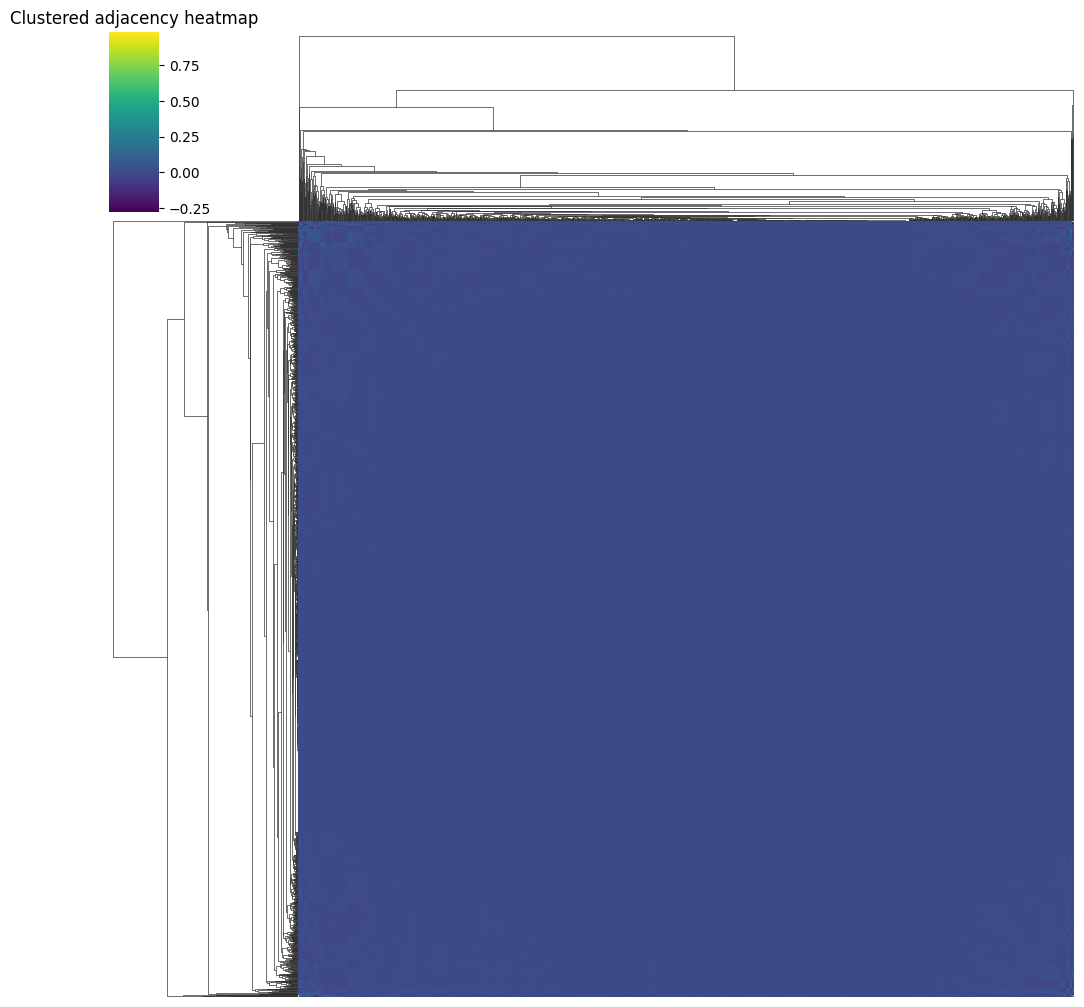

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use seaborn to cluster rows/columns based on similarity
sns.clustermap(
    adj_weighted_df,
    cmap="viridis",  # or 'coolwarm', 'magma', etc.
    figsize=(10, 10),
    xticklabels=False,
    yticklabels=False
)
plt.title("Clustered adjacency heatmap")
plt.show()


In [ ]:
# Whatever GRN method you choose, you need to use this code to reverse-engineer a "XYZ.npz" file
# that we will re-introduce to GenKI Variational Graph Autoencoder (VGAE) to conduct the KO simulation!
# Below some ideas from ChatGPT

In [33]:
# From an edge list → .npz
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix
from collections import defaultdict

def grn_from_edgelist(edge_df: pd.DataFrame,
                      genes: list,
                      source_col="source",
                      target_col="target",
                      weight_col="weight",
                      directed=True,
                      aggregate="sum"):
    """
    Build a CSR GRN from an edge list.
    - edge_df must have columns: source_col, target_col, weight_col (optional if you want binary)
    - genes is the ordered list used for rows/cols (must match your AnnData var_names order)
    - directed: if False, add symmetric edges (i->j and j->i)
    - aggregate: how to combine duplicate (i,j), one of {'sum','mean','max'}.
    """
    # Map genes → indices
    idx = {g:i for i,g in enumerate(genes)}

    # Filter to edges that exist in the gene set
    e = edge_df[
        edge_df[source_col].isin(idx) & edge_df[target_col].isin(idx)
    ].copy()

    # If no explicit weights, default to 1
    if weight_col not in e.columns:
        e[weight_col] = 1.0

    # Convert to integer indices
    rows = e[source_col].map(idx).to_numpy()
    cols = e[target_col].map(idx).to_numpy()
    vals = e[weight_col].astype(float).to_numpy()

    # If undirected, duplicate edges in the opposite direction
    if not directed:
        rows = np.concatenate([rows, cols])
        cols = np.concatenate([cols, rows[:len(e)]])  # careful to use pre-extended rows
        vals = np.concatenate([vals, vals])

    # Aggregate duplicate (row,col)
    bucket = defaultdict(list)
    for r, c, v in zip(rows, cols, vals):
        bucket[(r, c)].append(v)
    rr, cc, vv = [], [], []
    for (r, c), vs in bucket.items():
        if aggregate == "sum":
            agg = float(np.sum(vs))
        elif aggregate == "mean":
            agg = float(np.mean(vs))
        elif aggregate == "max":
            agg = float(np.max(vs))
        else:
            raise ValueError("aggregate must be one of {'sum','mean','max'}")
        rr.append(r); cc.append(c); vv.append(agg)

    coo = coo_matrix((vv, (rr, cc)), shape=(len(genes), len(genes)))
    csr = coo.tocsr()
    csr.sort_indices()
    return csr

def save_grn_npz(csr: csr_matrix, path: str):
    # Writes exactly the fields your loader expects
    np.savez(path,
             data=csr.data,
             indices=csr.indices,
             indptr=csr.indptr,
             shape=np.array(csr.shape, dtype=np.int64))

# Example usage:
# edge_list = pd.DataFrame({"source":["A","B"], "target":["C","A"], "weight":[0.9, 0.2]})
# genes = ["A","B","C"]  # must be the same order you’ll use later
# W = grn_from_edgelist(edge_list, genes, directed=True, aggregate="sum")
# save_grn_npz(W, "MyNewGRN.npz")


In [ ]:
# From an adjacency matrix (NumPy or Pandas) → .npz
def grn_from_adjacency(adj, genes: list):
    """
    Accepts a NumPy array or a Pandas DataFrame whose rows/cols are genes in the SAME order.
    Returns CSR.
    """
    if isinstance(adj, pd.DataFrame):
        # Ensure order matches the provided genes
        adj = adj.loc[genes, genes].to_numpy()
    else:
        adj = np.asarray(adj)
        if adj.shape != (len(genes), len(genes)):
            raise ValueError("Adjacency shape and genes length mismatch.")
    csr = csr_matrix(adj)
    csr.eliminate_zeros()
    csr.sort_indices()
    return csr

# Example:
# adj_df = pd.DataFrame(..., index=genes, columns=genes)
# W = grn_from_adjacency(adj_df, genes)
# save_grn_npz(W, "MyNewGRN_fromAdj.npz")


In [ ]:
# Quick round-trip sanity check
# Save
# save_grn_npz(W, "TestGRN.npz")

# Load (your current pattern)
ld = np.load("TestGRN.npz", allow_pickle=True)
W_loaded = csr_matrix((ld["data"], ld["indices"], ld["indptr"]), shape=tuple(ld["shape"]))

# Check equality
assert (W_loaded != W).nnz == 0 and W_loaded.shape == W.shape
print("Round-trip successful.")


# Notes: A Few Important Gotchas

- **Gene order is everything.**  
  Whatever gene order you use to build the matrix must match the order you’ll use later (e.g., `adata.var_names`).  
  Store the list alongside the `.npz` (e.g., `np.save("TestGRN_genes.npy", np.array(genes, dtype=object))`) to avoid mismatches.

- **Directed vs. undirected.**  
  GenKI usually treats edges as **directed** (row = source, col = target).  
  If your alternative GRN is undirected, decide whether to **symmetrize**.

- **Weights sign & scale.**  
  If your downstream logic expects signed weights (activation/inhibition), keep signs.  
  If you only have binary edges, set all weights to **1.0**.

- **Sparsity & sorting.**  
  Call `eliminate_zeros()` and `sort_indices()` before saving to keep the structure **tidy and fast**.


In [ ]:
# (Optional) If you need PyTorch GNN inputs later
# If you ever want to go from this CSR to a PyTorch COO (e.g., edge_index, edge_weight):

import torch

coo = W.tocoo()
edge_index = torch.tensor([coo.row, coo.col], dtype=torch.long)  # shape: [2, E]
edge_weight = torch.tensor(coo.data, dtype=torch.float32)        # shape: [E]


# Notes: Understanding `.npz` Files in NumPy

When you run:

np.savez("file.npz", array1=a, array2=b)

You’re actually creating a ZIP archive that contains:

- array1.npy
- array2.npy

Each one is a standard `.npy` file, and the `.npz` just bundles them together.

---

When you call:

loader = np.load("file.npz")

You get something that behaves like a dictionary:

loader.keys()       # e.g. ['array1', 'array2']
loader['array1']    # → returns the array you stored

---

## In your GenKI / GRN case

The `.npz` you loaded has **4 keys**:

- "data" → nonzero values of the sparse matrix
- "indices" → column indices of those values
- "indptr" → row pointer (where each row starts/ends in data)
- "shape" → matrix dimensions

This is exactly what SciPy’s **CSR sparse matrix** needs.  
In fact, `scipy.sparse.save_npz` / `scipy.sparse.load_npz` are just convenience wrappers around this format.


In [6]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix
import scanpy as sc

# ===== STEP 1: Load your existing GenKI GRN =====
print("Loading GenKI GRN...")
adata_kp12_dc_hvg = sc.read('../../Data/processed_data/adata_KP_1-2_hvg.h5ad')
genes = adata_kp12_dc_hvg.var_names.to_list()

# Load your GenKI adjacency matrix
pc_fp = "../../Scripts/GRNs/PertMap_Auto.npz"
loader = np.load(pc_fp, allow_pickle=True)
data, indices, indptr = loader['data'], loader['indices'], loader['indptr']
shape = tuple(loader['shape'])
W_sparse = csr_matrix((data, indices, indptr), shape=shape)

# Apply your existing threshold
thr = np.percentile(np.abs(W_sparse.data), 85)
W_bin = W_sparse.copy()
W_bin.data = (np.abs(W_bin.data) >= thr).astype(int)

print(f"Original GenKI GRN: {W_bin.shape[0]} genes, {W_bin.nnz} edges")

# ===== STEP 2: Process SHAP features =====
print("Processing SHAP features...")
shap_df = pd.read_csv('../../Task2_CMP/cross_modal_analysis_20250913_092044_keep/feature_feature_importance_3modalities.csv')

# Filter high-confidence SHAP relationships (threshold=0.4)
high_conf_shap = shap_df[shap_df['Value'] >= 0.1].copy()

# Process _SIG targets: "Ackr1_SIG" -> "Ackr1"
sig_mask = high_conf_shap['Target'].str.contains('_SIG', na=False)
processed_shap = high_conf_shap.copy()
processed_shap.loc[sig_mask, 'Target'] = processed_shap.loc[sig_mask, 'Target'].str.replace('_SIG', '')

# Filter for genes that exist in your GRN
valid_shap = processed_shap[
    (processed_shap['Source'].isin(genes)) & 
    (processed_shap['Target'].isin(genes))
].copy()

print(f"High-confidence SHAP relationships: {len(high_conf_shap)}")
print(f"SHAP relationships with genes in GRN: {len(valid_shap)}")

# ===== STEP 3: Create combined edge list (your approach) =====
print("Creating combined edge list...")

# Extract original GenKI edges
orig_rows, orig_cols = W_bin.nonzero()
original_edges_set = set(zip(orig_rows, orig_cols))

# Create edge list starting with GenKI edges
edges_data = []
g2i = {g: i for i, g in enumerate(genes)}

# Add GenKI edges first
for i, j in zip(orig_rows, orig_cols):
    edges_data.append({
        'source': genes[i],
        'target': genes[j],
        'weight': float(W_bin[i, j]),  # Usually 1 for binary
        'origin': 'GenKI'
    })

# Add SHAP edges (conservative: only where no GenKI edge exists)
new_shap_edges = 0
for _, edge in valid_shap.iterrows():
    src_idx = g2i[edge['Source']]
    tgt_idx = g2i[edge['Target']]
    
    # Only add if no existing GenKI edge
    if (src_idx, tgt_idx) not in original_edges_set:
        edges_data.append({
            'source': edge['Source'],
            'target': edge['Target'],
            'weight': 1.0,  # Binary adjacency
            'origin': 'SHAP'
        })
        new_shap_edges += 1

print(f"GenKI edges: {len(original_edges_set)}")
print(f"New SHAP edges added: {new_shap_edges}")
print(f"Total edges in augmented GRN: {len(edges_data)}")

# ===== STEP 4: Convert to sparse matrix (your exact approach) =====
edges_df = pd.DataFrame(edges_data)
edges_final = edges_df[["source", "target", "weight"]].copy()

# Your existing sparse matrix creation code:
rows = edges_final["source"].map(g2i).to_numpy()
cols = edges_final["target"].map(g2i).to_numpy()
vals = edges_final["weight"].astype(float).to_numpy()

W_augmented = coo_matrix((vals, (rows, cols)), shape=(len(genes), len(genes))).tocsr()
W_augmented.eliminate_zeros()
W_augmented.sort_indices()

# ===== STEP 5: Save in your NPZ format =====
def save_grn_npz(csr: csr_matrix, path: str):
    np.savez(path,
             data=csr.data,
             indices=csr.indices,
             indptr=csr.indptr,
             shape=np.array(csr.shape, dtype=np.int64))

# Save augmented GRN
output_prefix = "PertMap_Auto_SHAP_Augmented"
save_grn_npz(W_augmented, f"{output_prefix}.npz")
np.save(f"{output_prefix}_genes.npy", np.array(genes, dtype=object))

print(f"\n=== AUGMENTED GRN SAVED ===")
print(f"File: {output_prefix}.npz")
print(f"Genes: {output_prefix}_genes.npy")
print(f"Shape: {W_augmented.shape}")
print(f"Nonzeros: {W_augmented.nnz}")
print(f"Density change: {W_bin.nnz / (len(genes)**2):.6f} -> {W_augmented.nnz / (len(genes)**2):.6f}")

# ===== STEP 6: Verification =====
print(f"\n=== VERIFICATION ===")
print(f"Can load augmented GRN:")

# Test loading the saved file
test_loader = np.load(f"{output_prefix}.npz", allow_pickle=True)
test_data, test_indices, test_indptr = test_loader['data'], test_loader['indices'], test_loader['indptr']
test_shape = tuple(test_loader['shape'])
W_test = csr_matrix((test_data, test_indices, test_indptr), shape=test_shape)

print(f"✓ Loaded shape: {W_test.shape}")
print(f"✓ Loaded nonzeros: {W_test.nnz}")
print(f"✓ Matches original: {np.array_equal(W_test.data, W_augmented.data)}")

# Show edge origin breakdown
origin_counts = edges_df['origin'].value_counts()
print(f"\n=== EDGE ORIGIN BREAKDOWN ===")
for origin, count in origin_counts.items():
    percentage = count / len(edges_df) * 100
    print(f"{origin}: {count} edges ({percentage:.1f}%)")

print(f"\n🎉 SUCCESS: Augmented GRN ready for GenKI analysis!")
print(f"Use '{output_prefix}.npz' as input to your GenKI virtual KO experiments.")

# ===== OPTIONAL: Create edge list for inspection =====
print(f"\n=== SAVING EDGE LIST FOR INSPECTION ===")
edges_df.to_csv(f"{output_prefix}_edges.csv", index=False)
print(f"Edge list saved: {output_prefix}_edges.csv")

# Show some example SHAP edges added
shap_edges = edges_df[edges_df['origin'] == 'SHAP'].head(10)
if len(shap_edges) > 0:
    print(f"\nFirst 10 SHAP edges added:")
    for _, edge in shap_edges.iterrows():
        print(f"  {edge['source']} -> {edge['target']} (weight: {edge['weight']})")

Loading GenKI GRN...
Original GenKI GRN: 4001 genes, 15221702 edges
Processing SHAP features...
High-confidence SHAP relationships: 1845
SHAP relationships with genes in GRN: 1167
Creating combined edge list...
GenKI edges: 2283256
New SHAP edges added: 182
Total edges in augmented GRN: 2283438

=== AUGMENTED GRN SAVED ===
File: PertMap_Auto_SHAP_Augmented.npz
Genes: PertMap_Auto_SHAP_Augmented_genes.npy
Shape: (4001, 4001)
Nonzeros: 2283406
Density change: 0.950881 -> 0.142642

=== VERIFICATION ===
Can load augmented GRN:
✓ Loaded shape: (4001, 4001)
✓ Loaded nonzeros: 2283406
✓ Matches original: True

=== EDGE ORIGIN BREAKDOWN ===
GenKI: 2283256 edges (100.0%)
SHAP: 182 edges (0.0%)

🎉 SUCCESS: Augmented GRN ready for GenKI analysis!
Use 'PertMap_Auto_SHAP_Augmented.npz' as input to your GenKI virtual KO experiments.

=== SAVING EDGE LIST FOR INSPECTION ===
Edge list saved: PertMap_Auto_SHAP_Augmented_edges.csv

First 10 SHAP edges added:
  Ighg1 -> Akr1b7 (weight: 1.0)
  Mt2 -> Akr1

In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, save_npz
import scanpy as sc

# Load and create augmented matrix (same as before)
adata_kp12_dc_hvg = sc.read('../../Data/processed_data/adata_KP_1-2_hvg.h5ad')
genes = adata_kp12_dc_hvg.var_names.to_list()

pc_fp = "../../Scripts/GRNs/PertMap_Auto.npz"
loader = np.load(pc_fp, allow_pickle=True)
data, indices, indptr = loader['data'], loader['indices'], loader['indptr']
shape = tuple(loader['shape'])
W_sparse = csr_matrix((data, indices, indptr), shape=shape)

thr = np.percentile(np.abs(W_sparse.data), 85)
W_bin = W_sparse.copy()
W_bin.data = (np.abs(W_bin.data) >= thr).astype(int)

# SHAP processing (same as before)
shap_df = pd.read_csv('../../Task2_CMP/cross_modal_analysis_20250913_092044_keep/feature_feature_importance_3modalities.csv')
high_conf_shap = shap_df[shap_df['Value'] >= 0.1].copy()
sig_mask = high_conf_shap['Target'].str.contains('_SIG', na=False)
processed_shap = high_conf_shap.copy()
processed_shap.loc[sig_mask, 'Target'] = processed_shap.loc[sig_mask, 'Target'].str.replace('_SIG', '')

valid_shap = processed_shap[
    (processed_shap['Source'].isin(genes)) & 
    (processed_shap['Target'].isin(genes))
].copy()

# Create augmented matrix
W_augmented = W_bin.copy()
g2i = {g: i for i, g in enumerate(genes)}

new_edges = 0
for _, edge in valid_shap.iterrows():
    src_idx = g2i[edge['Source']]
    tgt_idx = g2i[edge['Target']]
    if W_augmented[src_idx, tgt_idx] == 0:
        W_augmented[src_idx, tgt_idx] = 1
        new_edges += 1

W_augmented = W_augmented.tocsr()
W_augmented.eliminate_zeros()
W_augmented.sort_indices()

# FIXED: Use GenKI-compatible save format
save_npz("../GRNs/PertMap_Auto_SHAP_Augmented.npz", W_augmented)

print(f"✅ GenKI-compatible file saved!")
print(f"Added {new_edges} SHAP edges")

/home/ggavriilidis/.conda/envs/unitednet/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


✅ GenKI-compatible file saved!
Added 150 SHAP edges
